<a href="https://colab.research.google.com/github/FrancescoZanni/Temperature/blob/main/Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preliminary imports and setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.7 MB/s eta 0:00:00


In [ ]:
!pip install corner

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import json
import os
from scipy.optimize import curve_fit
from matplotlib.pyplot import figure
import emcee
import corner
import random
from datetime import datetime
from scipy import integrate
import matplotlib as mpl


In [ ]:

ls

In [ ]:
cd drive/MyDrive/KAGGLE

In [ ]:
mkdir -p temperature

In [ ]:

cd temperature

In [ ]:
ls

##Import of the dataset from my google drive

In [ ]:
raw_data = pd.read_csv("city_temperature.csv")

Initial data exploration

In [ ]:
raw_data.columns

In [ ]:
raw_data.head()

In [ ]:
raw_data.State.unique()

In [ ]:

for c in raw_data.Region.unique():
  print(c)

State, Country and Region columns are not useful so I delete them \\



In [ ]:
raw_data = raw_data.drop("State", axis = 1);
raw_data = raw_data.drop("Region", axis = 1);
raw_data = raw_data.drop("Country", axis = 1);

Checking for missing values (NaN)

In [ ]:
print(raw_data.isna().sum())

##Next I handle the dates

In [ ]:
print(raw_data.Day.unique())
print(raw_data.Month.unique())
print(raw_data.Year.unique())

In [ ]:
#Unique values present in the rows where the day number is 0:
raw_data[raw_data.Day == 0 ].AvgTemperature.unique()

In [ ]:
#Removing every row where the day value is set to 0
raw_data = raw_data[raw_data.Day !=0]


In [ ]:
#Unique values present in the rows where the year number is 200 or 201:
print(raw_data[raw_data.Year == 200].AvgTemperature.unique())
print(raw_data[raw_data.Year == 201].AvgTemperature.unique())

In [ ]:
raw_data = raw_data.drop(raw_data[raw_data.Year ==200].index)
raw_data = raw_data.drop(raw_data[raw_data.Year ==201].index)

In [ ]:
#Deleting all leap year Feb 29th
raw_data = raw_data.drop(raw_data[(raw_data['Month'] == 2) & (raw_data['Day'] == 29)].index)

In [ ]:
#Creating the date column as Datetime objects
raw_data['date'] = pd.to_datetime(raw_data[['Year', 'Month', 'Day']], yearfirst = True)

In [ ]:
#Dropping the unneded columns
raw_data.drop("Year", axis = 1, inplace = True)
raw_data.drop("Month", axis = 1, inplace = True)
raw_data.drop("Day", axis = 1, inplace = True)
raw_data

In [ ]:
#defining the initial date and the IncrementalDate column
start_date = raw_data.date.min()
raw_data["IncrementalDate"] = raw_data.date - start_date
raw_data["IncrementalDate"] = raw_data["IncrementalDate"].dt.days

In [ ]:
#The prepared dataframe is this
raw_data

In [ ]:
print("Total number of cities: ", raw_data.City.unique().size)

##Missing values
Next I plot the data from the city of Barcelona to have a first look: there are missing values set to -99

In [ ]:

ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.plot(raw_data[raw_data.City == "Barcelona"].IncrementalDate,raw_data[raw_data.City == "Barcelona"].AvgTemperature, label = "Data")
ax.set_ylabel("Average temperature (°F)")
ax.set_xlabel("Incremental date")
ax.set_title("Barcelona raw data")
ax.grid(True)


For a random subset of 20 cities the percentage of missing values over all values is shown


In [ ]:
 a = np.zeros(len(raw_data.City.unique()))
 i = 0
 for c in raw_data.City.unique():
   a[i]=raw_data[raw_data.City ==c][raw_data.AvgTemperature ==-99].AvgTemperature.count()/ raw_data[raw_data.City==c].AvgTemperature.count ()*100
   i=i+1

In [ ]:
elenco = {}
i= 0
for c in raw_data.City.unique():
  elenco[c]=a[i]
  i = i+1
print(elenco)
print(elenco["Barcelona"])

In [ ]:
missingbarc = raw_data[raw_data.City =="Barcelona"][raw_data.AvgTemperature ==-99].AvgTemperature.count()/ raw_data[raw_data.City=="Barcelona"].AvgTemperature.count ()*100

In [ ]:
pl.hist(a,range = [0,0.5], bins = 25)
pl.title("Percentage of missing data across cities")
pl.xlabel("Missing data (%)")
pl.ylabel("Frequency")
pl.grid()
pl.axvline(x=missingbarc, color='red', linestyle='--', label='Barcelona')
pl.legend()

Fill in the missing values by interpolating the previous and the next value \\
Convert from Farenheit to Cesius

In [ ]:
# Fill the missing values by linear interpolation of previous and next value

raw_data['AvgTemperature'] = raw_data['AvgTemperature'].replace(-99, float('nan'))
raw_data['AvgTemperature'] = raw_data['AvgTemperature'].interpolate( "linear")

#conversion from Fareheit to Celsius
raw_data['AvgTemperature'] = (raw_data['AvgTemperature']-32)/1.8

In [ ]:
first_day = np.array(raw_data[raw_data.City == "Barcelona"].date.unique())[0]
last_day = np.array(raw_data[raw_data.City == "Barcelona"].date.unique())[-1]
print(first_day)
print(last_day)
print((last_day-first_day).astype('timedelta64[D]'))

In [ ]:
random.seed(422)
for c in random.sample(sorted(raw_data.City.unique()),10):
    print(np.array(raw_data[raw_data.City == c].date.unique())[-1])
    ax = pl.figure(figsize=(5,5)).add_subplot(111)
    ax.plot(raw_data[raw_data.City == c]["IncrementalDate"],raw_data[raw_data.City==c].AvgTemperature)
    ax.set_title(c)
    ax.set_ylabel("AvgTemperature")

Check that the missing values are correctly removed

In [ ]:
raw_data

In [ ]:

ax = pl.figure(figsize=(7,5)).add_subplot(111)
ax.plot(raw_data[raw_data.City == "Barcelona"].AvgTemperature)
ax.set_title("Barcelona Average temperatures")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")


In [ ]:
pl.plot(raw_data[raw_data.City == "Barcelona"].IncrementalDate- np.arange(len(raw_data[raw_data.City == "Barcelona"].IncrementalDate)))

##Histograms of the distibution of temperature for a random subset of 10 cities

In [ ]:
  random.seed(3432)
  for c in random.sample(sorted(raw_data.City.unique()),10):
    ax = pl.figure(figsize=(5,5)).add_subplot(111)
    ax.hist(raw_data[raw_data.City==c].AvgTemperature)
    ax.set_title(c)
    ax.set_ylabel("frequency")


# Definition of the model and parameter fitting

Seasonality: $$s(t) = a_0 + bt + a1 \sin\Bigg(2\pi\frac{t+f}{365}\Bigg) +  b1 \cos\Big(2\pi\frac{t+g}{365}\Big)$$

In [ ]:
#parameters
a0 = 1
b = 0.001
a1 = 1
b1 = 1
f = 0
g = 0



def s(t, a0, a1, b, b1, f, g):
    return a0 + b*t + a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)

Variance:
$$ \sigma^2 (t)=c+\sum_{i=1}^{4}c_i\sin\Big(\frac{2i\pi t}{365}\Big)+\sum_{j=1}^{4}d_j \cos\Big(\frac{2j\pi t}{365}\Big)$$

Definition of a trial set to explore the methodology \\
I take the temperature data from the city of Barcelona


In [ ]:

#y is the array with the average temperature of Barcelona
y = np.array(raw_data[raw_data.City == "Barcelona"].AvgTemperature)
#x is the array with the incremental dates
x =  np.array(raw_data[raw_data.City == "Barcelona"].IncrementalDate)
print(x.size)

In [ ]:
ax = pl.figure(figsize=(7,5)).add_subplot(111)
ax.plot(x,y)
ax.set_title("Barcelona Average temperatures")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")


##Linear regression to find out the temperature growth trend#
Proceeding as in https://www.duo.uio.no/bitstream/handle/10852/10566/pm12-05.pdf?sequence=1  \\
First with a linear fit to compute the upward linear trend in the s(t)

In [ ]:

def moving_average(arr, window_size):
    if window_size <= 0 or window_size > len(arr):
        raise ValueError("Invalid window size")

    moving_averages = []
    for i in range(len(arr)):
        start = max(0, i - window_size + 1)
        end = i + 1
        window = arr[start:end]
        avg = sum(window) / len(window)
        moving_averages.append(avg)

    return moving_averages

# Example usage:

window_size = 365
averages = moving_average(y, window_size)

In [ ]:

def line(x, a, b):
    return a * x + b


params_line, covariance = curve_fit(line, x, y)

# Extract the optimized parameters
a, b = params_line

# Generate fitted data using the optimized parameters
y_linearfit = line(x, a, b)

# Plot the original data and the fitted function


ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_linearfit, 'r-', label='Fitted Function')
ax.plot(x,averages, 'm-', label="365 days moving average")
ax.set_title("Linear trend fitting")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

perr_line = np.sqrt(np.diag(covariance))




print(f"Fitted parameters: a0 = {b} +/- {perr_line[1]}, b = {a} +/- {perr_line[0]}")


In [ ]:
print("The trend sees the temperature growing of 1C every {0:2.2f} years".format(1/(a*365)))
#Subtract the upward trend to isolate the seasonality
y_detrended = y-line(x,a,b)

##Regression to find out the seasonality parameters
After subtracting the linear trend the periodic part of the seasonality is computed

In [ ]:
#definition of the s(t) function without the linear trend
def s_detrended(t, a1, b1, f, g):
    return a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)

In [ ]:
#Fitting
params_detrended, cov = curve_fit(s_detrended, x, y_detrended)
perr_sine = np.sqrt(np.diag(cov))

In [ ]:
print("Parameters found are: ")
print("a0: ", params_detrended[0], "+/-", perr_sine[0])
print("b0: ", params_detrended[1], "+/-", perr_sine[1])
print("f: ", params_detrended[2], "+/-", perr_sine[2])
print("g: ", params_detrended[3], "+/-", perr_sine[3])

In [ ]:


ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y_detrended, label = "Data", s=2)
ax.plot(x,s_detrended(x,*params_detrended), 'r-', label='Fitted Function')
ax.set_title("Periodic seasonality")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

In [ ]:
#complete set of parameters
params_complete = [a,b,*params_detrended]
# Generate fitted data using the optimized parameters
y_fit = line(x,a,b)+s_detrended(x, *params_detrended)

# Plot the original data and the fitted function


ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_fit, 'r-', label='Fitted Function')
ax.set_title("Combined result")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)


##Fitting the whole s(t) all at once

This consists in fitting the entire s(t) in one time instead of isolating the linear trend first, so it differs from the cited paper.


In [ ]:
params, cov = curve_fit(s, x, y)
perr_complete = np.sqrt(np.diag(cov))

y_fitcomplete = s(x, *params)

# Plot the original data and the fitted function
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_fitcomplete, 'r-', label='Fitted Function')
ax.set_title("Complete seasonality fit")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

print("Parameter obtained:")
print("a0: ", params[0], "+/-", perr_complete[0])
print("a1: ", params[1], "+/-", perr_complete[1])
print("b0: ", params[2], "+/-", perr_complete[2])
print("b1: ", params[3], "+/-", perr_complete[3])
print("f: ", params[4], "+/-", perr_complete[4])
print("g: ", params[5], "+/-", perr_complete[5])


In [ ]:
print("Comparison of the two methods: ")
print(f"First: ", params_complete)
print(f"Second: ", params)

#pl.scatter(x, y, label='Data')
# pl.plot(x, y_fitcomplete, 'r-', label='second')
# pl.plot(x, y_fit, 'm-', label = "first")
# pl.legend()
# pl.xlabel('x')
# pl.ylabel('y')
# pl.title('Fitting s(t)')
# pl.show()


# Plot the original data and the fitted function
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2, alpha = 0.5)
ax.plot(x,y_fitcomplete, color = "purple", label='One-Step Fitting', linewidth = 2)
ax.plot(x,y_fit, color = "green", label ="Two-steps Fitting", linewidth = 2)
ax.set_title("Comparison of the two methods")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)


print("One step accuracy: ",  np.sum((y-y_fitcomplete)**2))
print("Two step accuracy: ",  np.sum((y-y_fit)**2))
print("comparison ",  np.sum((y-y_fitcomplete)**2)/np.sum((y-y_fit)**2))


In [ ]:
pl.plot(x[0:1000], y_fitcomplete[0:1000]-y_fit[0:1000], 'r-', label='second')


Very different parameters but same result (?)

##Including more Fourier modes


In [ ]:

def s_4modes(t, a0, a1, a2 , b, b1, b2, f1, f2,  g1, g2):
    return a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365) + b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)

def s_6modes(t, a0, a1, a2, a3, b, b1, b2, b3,  f1, f2, f3,  g1, g2, g3):
    return (a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365)+ a3 * np.sin(6*np.pi*(t+f3)/365) + \
     b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)+ b3 * np.cos(6*np.pi*(t+g3)/365))



In [ ]:

params_4modes, cov_4modes = curve_fit(s_4modes, x, y)
perr_4modes = np.sqrt(np.diag(cov_4modes))


y_fit_4modes = s_4modes(x, *params_4modes)

# Plot the original data and the fitted function
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_fit_4modes, 'r-', label='Fitted Function')
ax.set_title("Truncation to two sines and 2 cosines")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

In [ ]:


params_6modes, cov_6modes = curve_fit(s_6modes, x, y)
perr_6modes = np.sqrt(np.diag(cov_6modes))


y_fit_6modes = s_6modes(x, *params_6modes)

# Plot the original data and the fitted function
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_fit_6modes, 'r-', label='Fitted Function')
ax.set_title("Truncation to three sines and three cosines")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

In [ ]:

ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2, alpha = 0.5)
ax.plot(x,y_fitcomplete, color = "purple", label='2 modes', linewidth = 2)
ax.plot(x,y_fit_4modes, color = "green", label ="4 Modes", linewidth = 2)
ax.plot(x,y_fit_6modes, color = "Magenta", label ="6 Modes", linewidth = 1)
ax.set_title("Comparison of different truncations")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)
print(params_4modes)
print(params_6modes)

In [ ]:
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x[1:900],y[1:900], label = "Data", s=2, alpha = 0.5)
ax.plot(x[1:900],y_fitcomplete[1:900], color = "purple", label='2 modes', linewidth = 2)
ax.plot(x[1:900],y_fit_4modes[1:900], color = "green", label ="4 Modes", linewidth = 2)
ax.plot(x[1:900],y_fit_6modes[1:900], color = "Magenta", label ="6 Modes", linewidth = 1)
ax.set_title("Comparison of different truncations")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)


In [ ]:
def s_8modes(t, a0, a1, a2, a3, a4, b, b1, b2, b3, b4,  f1, f2, f3, f4,  g1, g2, g3, g4):
    return (a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365)+ a3 * np.sin(6*np.pi*(t+f3)/365)+ a4 * np.sin(8*np.pi*(t+f4)/365) + \
     b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)+ b3 * np.cos(6*np.pi*(t+g3)/365)+ b4 * np.cos(8*np.pi*(t+g4)/365))


params_8modes, cov_8modes = curve_fit(s_8modes, x, y)
perr_8modes = np.sqrt(np.diag(cov_8modes))
y_fit_8modes = s_8modes(x, *params_8modes)

def s_10modes(t, a0, a1, a2, a3, a4, a5, b, b1, b2, b3, b4, b5,  f1, f2, f3, f4, f5,  g1, g2, g3, g4, g5):
    return (a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365)+ a3 * np.sin(4*np.pi*(t+f3)/365) + a4 * np.sin(8*np.pi*(t+f4)/365) + a5 * np.sin(10*np.pi*(t+f5)/365) \
     + b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)+ b3 * np.cos(6*np.pi*(t+g3)/365)+ b4 * np.cos(8*np.pi*(t+g4)/365)+ b5 * np.cos(10*np.pi*(t+g5)/365))


params_10modes, cov_10modes = curve_fit(s_10modes, x, y)
perr_10modes = np.sqrt(np.diag(cov_10modes))
y_fit_10modes = s_10modes(x, *params_10modes)

def s_12modes(t, a0, a1, a2, a3, a4, a5, a6, b, b1, b2, b3, b4, b5, b6,  f1, f2, f3, f4, f5, f6,  g1, g2, g3, g4, g5, g6):
    return (a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365)+ a3 * np.sin(4*np.pi*(t+f3)/365) + a4 * np.sin(8*np.pi*(t+f4)/365) + a5 * np.sin(10*np.pi*(t+f5)/365)+ a6 * np.sin(12*np.pi*(t+f6)/365)+ \
     b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)+ b3 * np.cos(6*np.pi*(t+g3)/365)+ b4 * np.cos(8*np.pi*(t+g4)/365)+ b5 * np.cos(10*np.pi*(t+g5)/365)+ b6 * np.cos(12*np.pi*(t+g6)/365))


params_12modes, cov_12modes = curve_fit(s_12modes, x, y)
perr_12modes = np.sqrt(np.diag(cov_12modes))
y_fit_12modes = s_12modes(x, *params_12modes)


##Accuracy metric for the 3 fits

In [ ]:
modes = [1, 2, 3, 4, 5, 6]
L2_modes = np.zeros(6)
L2_modes[0] = np.sum((y-y_fitcomplete)**2)
L2_modes[1] = np.sum((y-y_fit_4modes)**2)
L2_modes[2] = np.sum((y-y_fit_6modes)**2)
L2_modes[3] = np.sum((y-y_fit_8modes)**2)
L2_modes[4] = np.sum((y-y_fit_10modes)**2)
L2_modes[5] = np.sum((y-y_fit_12modes)**2)




ax = pl.figure(figsize=(7,5)).add_subplot(111)
ax.plot(modes,L2_modes)
ax.plot(modes,L2_modes, "*")
ax.set_title('L2 Accuracy comparison')
ax.set_xlabel("Number of sine and cosine modes")
ax.set_ylabel("sum of squared residuals")
ax.grid(True)
#ax.set_xlim(0.9,6.1)
#ax.set_ylim(0.8,1.2)
print(L2_modes[0])


#Maximum likelihood whith Monte Carlo



In [ ]:
#theta is the parameters array
#theta = [a0,a1,b,b1,f,g]

In [ ]:
def log_prior(theta):
  #no prior constraints on the parameters
  return 0

In [ ]:
def log_likelihood(theta, x, y):
  a0,a1,b,b1,f,g = theta
  #set the likelihood as the sum of the squared residuals
  return -np.sum((y-s(x, *theta))**2)

In [ ]:
def log_probability(theta, x, y):
  #since there is no prior the probability is the likelihood
  return log_likelihood(theta,x,y)

##MCMC to explore the parameter space

In [ ]:
#ig = params_complete  #initial guess set to the parameters found by the previous fitting (the idea is to have less burn-in)
ig = [1,1,1,1,1,1] #uninformed initial guess
ndim = len(ig)
nwalkers = 16
pos = np.array(ig)+ 1 * np.random.randn(nwalkers,ndim) #starting positions randomized around the initial guess

pos.shape

(16, 6)

Slow computation!

In [ ]:
# #Using emcee to explore the parameter space
np.random.seed(14234)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 7000, progress=True); #run the emcee for 20000 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=1500, thin=15, flat=True) #throw away burn in phase


100%|██████████| 7000/7000 [01:24<00:00, 82.68it/s]


In [ ]:

results = np.zeros((ndim,1))
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])   #extract the interquartile range and median solution for each parameter
  results[i] = np.mean(flat_samples[:,i])   #extract the mean points
print(results)
print(np.size(results))
print(np.size(mcmc[:,1]))


[[ 1.62023351e+01]
 [-3.83170734e+00]
 [ 8.94443232e-05]
 [-5.97755392e+00]
 [ 1.22721660e+01]
 [ 6.09780615e-01]]
6
6


In [62]:

save = [ 1.62025063e+01,
  3.55955050e+00,
  8.89221597e-05,
 -4.44286574e+00,
 -1.36237623e+02,
 -1.87900621e+01]

results = save

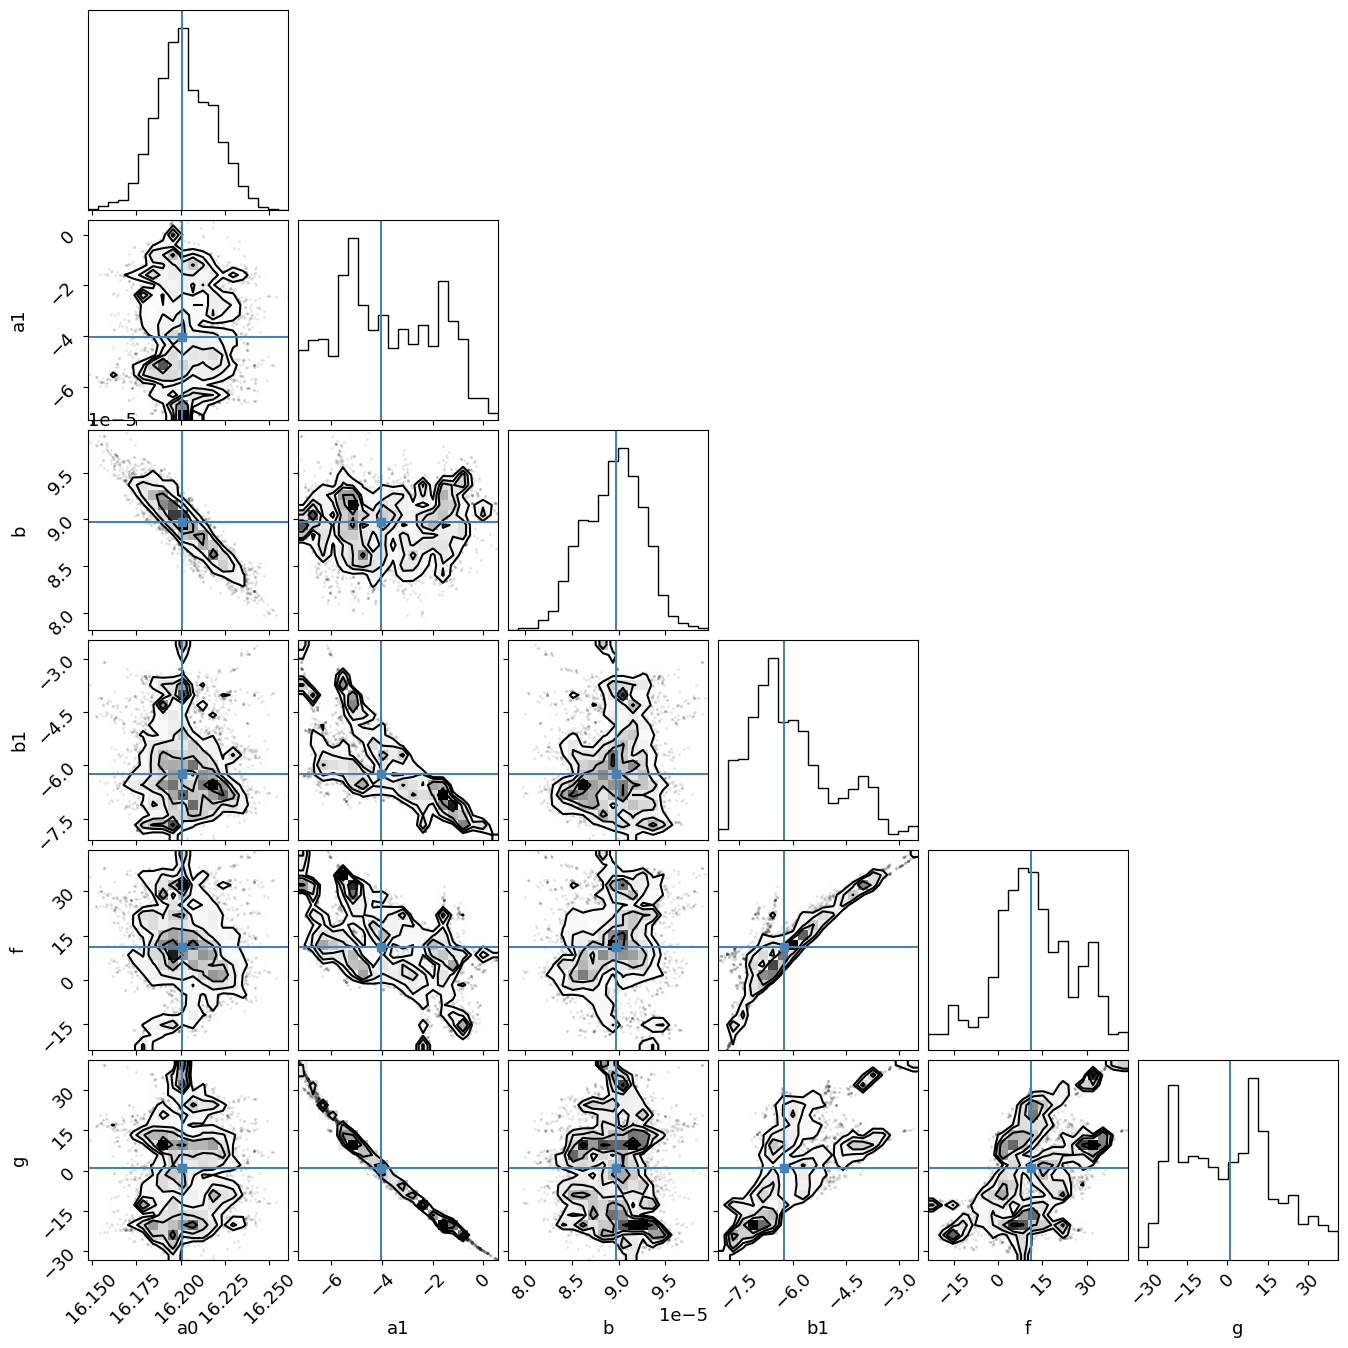

In [ ]:
#triangle plot to visualize the parameter distributions (something broken?)
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a0","a1","b","b1","f","g"], truths=mcmc[:,1]);

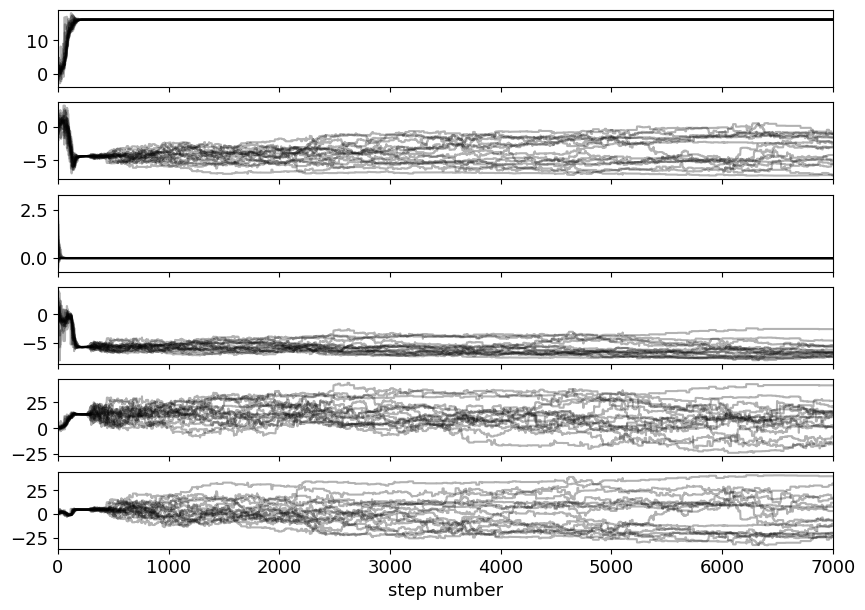

In [ ]:
#Visualise the Markov chains (not ideal)
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

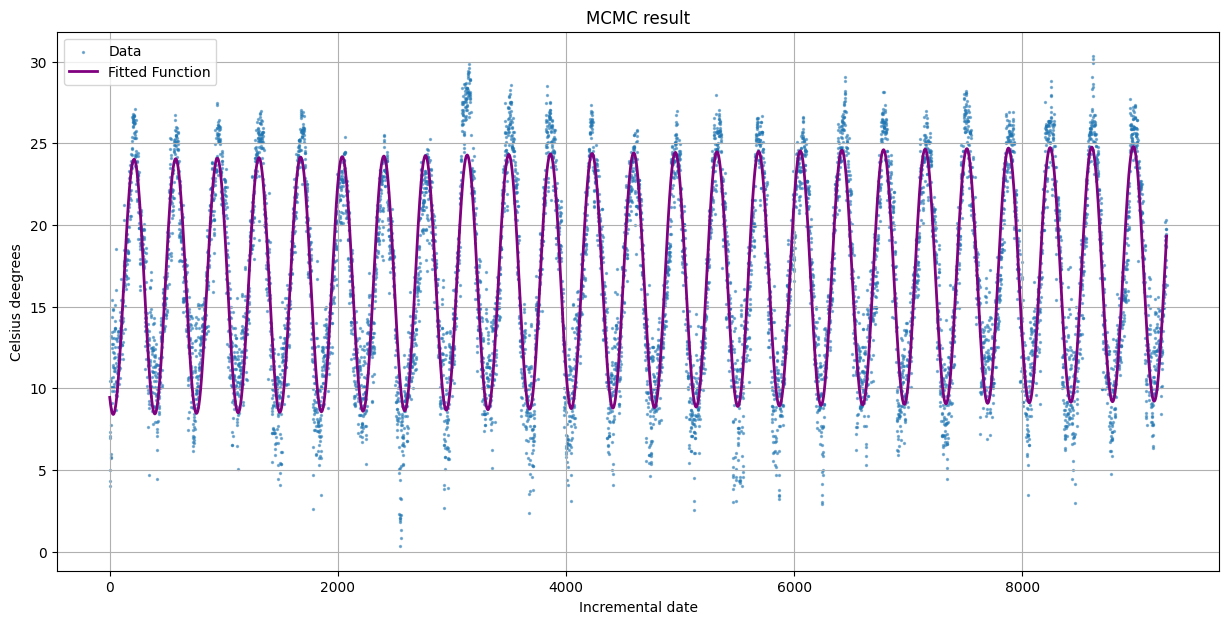

In [ ]:
#Repeat the plot with the new parameters obtained

y_MCMC = s(x, *results)

ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2, alpha = 0.5)
ax.plot(x,y_MCMC, color = "purple", label='Fitted Function', linewidth = 2)
ax.set_title("MCMC result")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

In [ ]:
print("Curve fit parameters: ", params_complete)
print("Monte Carlo parameters", results)

Curve fit parameters:  [7.501642047180734e-05, 16.20059460399077, 3.1435220236832313, -5.030081708819582, -145.0237133988607, -15.033324851476943]
Monte Carlo parameters [16.2025063, 3.5595505, 8.89221597e-05, -4.44286574, -136.237623, -18.7900621]


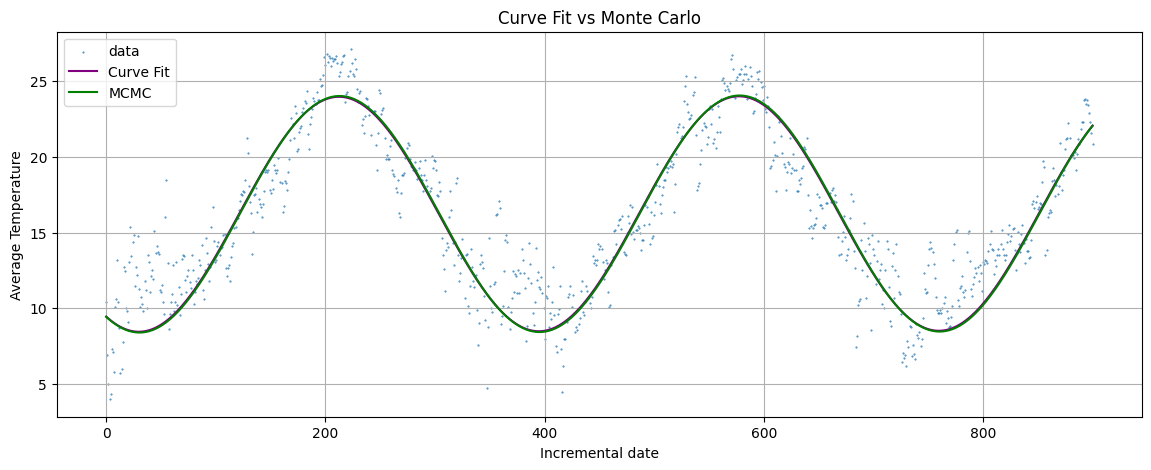

In [ ]:


fig, ax = pl.subplots(figsize = (14,5))

ax.scatter(x[0:900],y[0:900], label ="data", s=.2)
ax.plot(x[0:900],y_fitcomplete[0:900],  label = "Curve Fit", linewidth = 1.5, color = "purple")
ax.plot(x[0:900],y_MCMC[0:900], label="MCMC", linewidth = 1.5, color = "green")
ax.legend()
ax.set_xlabel("Incremental date")
ax.set_ylabel("Average Temperature")
ax.set_title("Curve Fit vs Monte Carlo")
ax.grid(True)


In [ ]:
#Accuracy metric for MCMC

L2_MCMC = np.sum((y-y_MCMC)**2)

print(L2_modes[0])
print(L2_MCMC)
print(L2_MCMC/L2_modes[0])

46271.50689934291
46319.1150979043
1.0010288880080123


#Fitting of the volatility



In [63]:
#substract the seasonality to isolate the volatility
y_deseason = y- y_fit

Text(0.5, 1.0, 'De-trended and de-seasonalized temperature')

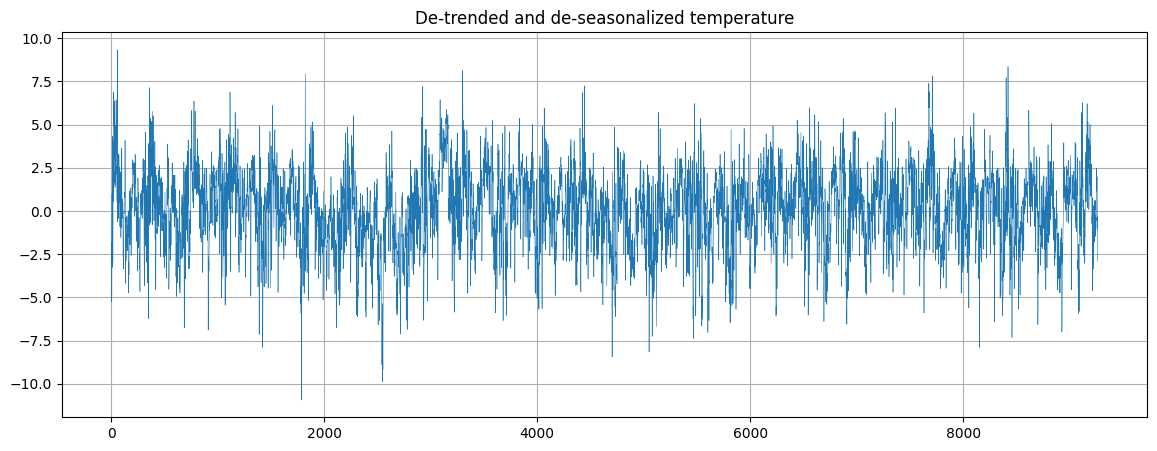

In [64]:
from pandas.core.reshape.api import wide_to_long
fig, ax = pl.subplots(figsize = (14,5))

ax.plot(x,y_deseason, linewidth = .4)
ax.grid(True)
ax.set_title("De-trended and de-seasonalized temperature")

Text(0, 0.5, '$ \\tilde{T}^2$')

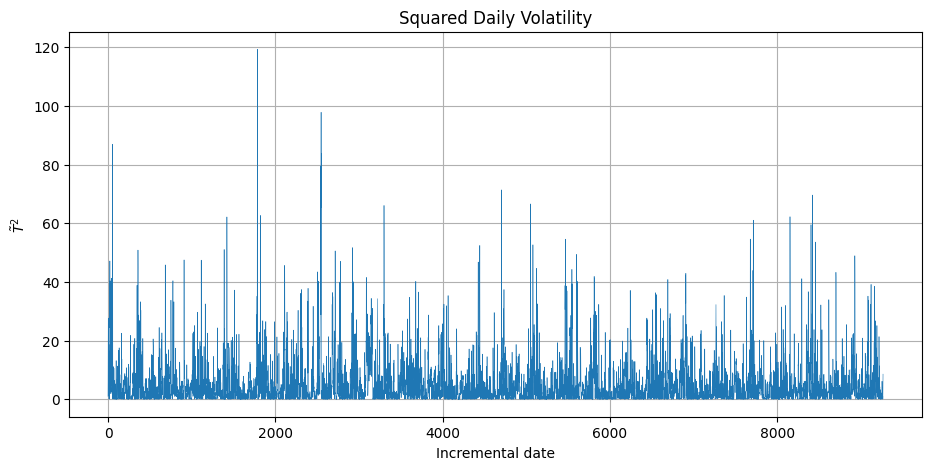

In [65]:
fig, ax = pl.subplots(figsize = (11,5))
pl.rcParams['text.usetex'] = True

ax.plot(x,y_deseason**2, linewidth = .4)
ax.grid(True)
ax.set_title("Squared Daily Volatility")
ax.set_xlabel("Incremental date")
ax.set_ylabel(r'$ \tilde{T}^2$')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


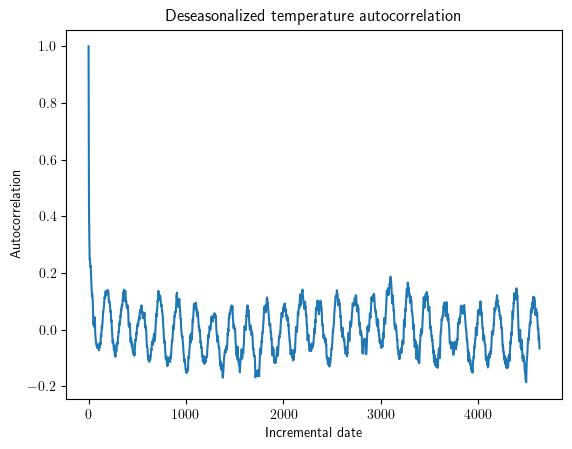

In [66]:
#Autocorrelation function


def autocorr(vector, T):
    cc = np.ones(T)
    for t in range(T):
      cc[t] = np.mean(vector[0:(T-t-1)] * vector[t:(T-1)])

    cc = cc - np.mean(vector)**2
    cc = cc/cc[0]

    if T >= len(vector)/2:
      return cc[0:round(len(vector)/2)]
    else:
      return cc



auto = autocorr(y_deseason, len(y_deseason))

pl.plot(auto)
pl.title("Deseasonalized temperature autocorrelation")
pl.xlabel("Incremental date")
pl.ylabel("Autocorrelation")
pl.show()

###Average volatility per day
Build the average for each day of the year in order to show the seasonality traits of the volatility

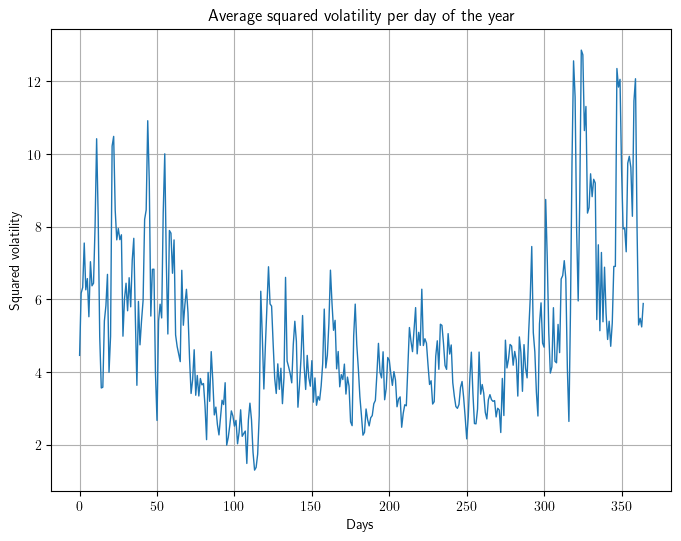

In [67]:
avg_vol = np.zeros(365)
n_years = np.zeros(365)
year = np.arange(365)



for i in range(len(x)):
  for j in range(365):
    if i % 365 == j:
      avg_vol[j]= avg_vol[j] + y_deseason[i]**2
      n_years[j]= n_years[j]+1

for j in range(365):

  avg_vol[j] = avg_vol[j]/n_years[j]





fig, ax = pl.subplots(figsize = (8,6))
ax.plot(year,avg_vol, linewidth = 1)
ax.grid(True)
ax.set_title("Average squared volatility per day of the year")
ax.set_xlabel("Days")
ax.set_ylabel("Squared volatility");

##Fitting Sigma1

In [68]:

def sigmasq(t, c, c1, d1):
  return (c + c1*np.sin((2*np.pi*t)/(365)) + d1*np.cos((2*np.pi*t)/(365)))

In [69]:
sigma_params, sigma_cov1 = curve_fit(sigmasq, year, avg_vol)
sigma_fit_1 = sigmasq(year, *sigma_params);

[ 5.00299935 -0.26019664  1.87060058]
[0.008905   0.01781001 0.01781001]


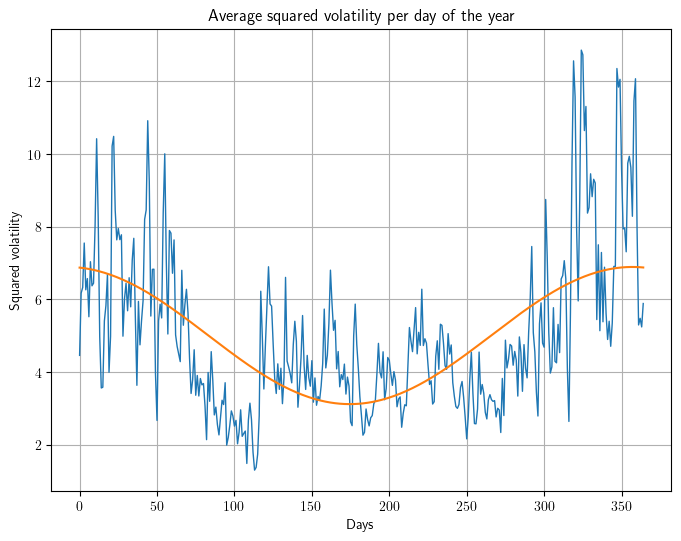

In [70]:
fig, ax = pl.subplots(figsize = (8,6))

ax.plot(year,avg_vol, linewidth = 1)
ax.plot(year, sigma_fit_1)

ax.grid(True)
ax.set_title("Average squared volatility per day of the year")
ax.set_xlabel("Days")
ax.set_ylabel("Squared volatility")

print(sigma_params)
print(np.diagonal(sigma_cov1))

##Fitting sigma 2

In [71]:
def sigmasq2(t,c,c1,c2,d1,d2):
  return (c+ c1*np.sin((2*np.pi*t)/(365))+ c2*np.sin((4*np.pi*t)/(365))+\
  d1*np.cos((2*np.pi*t)/(365))+ d2*np.cos((4*np.pi*t)/(365)))

In [72]:
sigma_params2, sigma_cov = curve_fit(sigmasq2, year, avg_vol)
sigma_fit_2 = sigmasq2(year, *sigma_params2);

In [73]:
fig, ax = pl.subplots(figsize = (8,6))

ax.plot(year,avg_vol, linewidth = 1)
ax.plot(year, sigma_fit_2)

ax.grid(True)
ax.set_title("Average squared volatility per day of the year")
ax.set_xlabel("Days")
ax.set_ylabel("Squared volatility")
pl.show()
print(sigma_params2)
print(np.diagonal(sigma_cov))

[ 5.00299935 -0.26019663 -0.28864732  1.87060056  1.09615769]
[0.00716992 0.01433985 0.01433985 0.01433985 0.01433985]


##Fitting Sigma4


In [74]:
def sigmasq4(t, c, c1,c2,c3,c4, d1,d2,d3,d4):
  return (c+ c1*np.sin((2*np.pi*t)/(365))+ c2*np.sin((4*np.pi*t)/(365))+ c3*np.sin((6*np.pi*t)/(365))+ c4*np.sin((8*np.pi*t)/(365))+\
  d1*np.cos((2*np.pi*t)/(365))+ d2*np.cos((4*np.pi*t)/(365))+ d3*np.cos((6*np.pi*t)/(365))+ d4*np.cos((8*np.pi*t)/(365)))

In [75]:
sigma_params4, sigma_cov = curve_fit(sigmasq4, year, avg_vol)
sigma_fit_4 = sigmasq4(year, *sigma_params4);

In [76]:
fig, ax = pl.subplots(figsize = (8,6))

ax.plot(year,avg_vol, linewidth = 1)
ax.plot(year, sigma_fit_4)

ax.grid(True)
ax.set_title("Average squared volatility per day of the year")
ax.set_xlabel("Days")
ax.set_ylabel("Squared volatility")

print(sigma_params4)
print(np.diagonal(sigma_cov))

[ 5.00299936 -0.26019665 -0.28864732 -0.12378889 -0.30088719  1.87060057
  1.09615769 -0.10645857 -0.79184808]
[0.00620524 0.01241048 0.01241048 0.01241048 0.01241048 0.01241048
 0.01241048 0.01241048 0.01241048]


###Autocorrelations

In [77]:
ac0 = autocorr(y_deseason**2 , len(y_deseason))
ac1 = autocorr(y_deseason**2 - sigmasq(x,*sigma_params), len(y_deseason))
ac2 = autocorr(y_deseason**2 - sigmasq2(x,*sigma_params2), len(y_deseason))
ac4 = autocorr(y_deseason**2 - sigmasq4(x,*sigma_params4), len(y_deseason))

fig, ax = pl.subplots(figsize = (8,6))

ax.plot(np.arange(len(y_deseason)/2),ac0, linewidth = 1, label = r' $\tilde{T}$')
ax.plot(np.arange(len(y_deseason)/2),ac1, linewidth = 1, label = r' $\tilde{T}-\sigma(t)_1^2$')
ax.plot(np.arange(len(y_deseason)/2),ac2, linewidth = 1, label = r' $\tilde{T}-\sigma(t)_2^2$')
ax.plot(np.arange(len(y_deseason)/2),ac4, linewidth = 1, label = r' $\tilde{T}-\sigma(t)_4^2$')

ax.grid(True)
ax.set_title("Autocorrelation comparison")
ax.set_xlabel("Days")
ax.set_ylabel("Autocorrelation")
ax.legend()




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


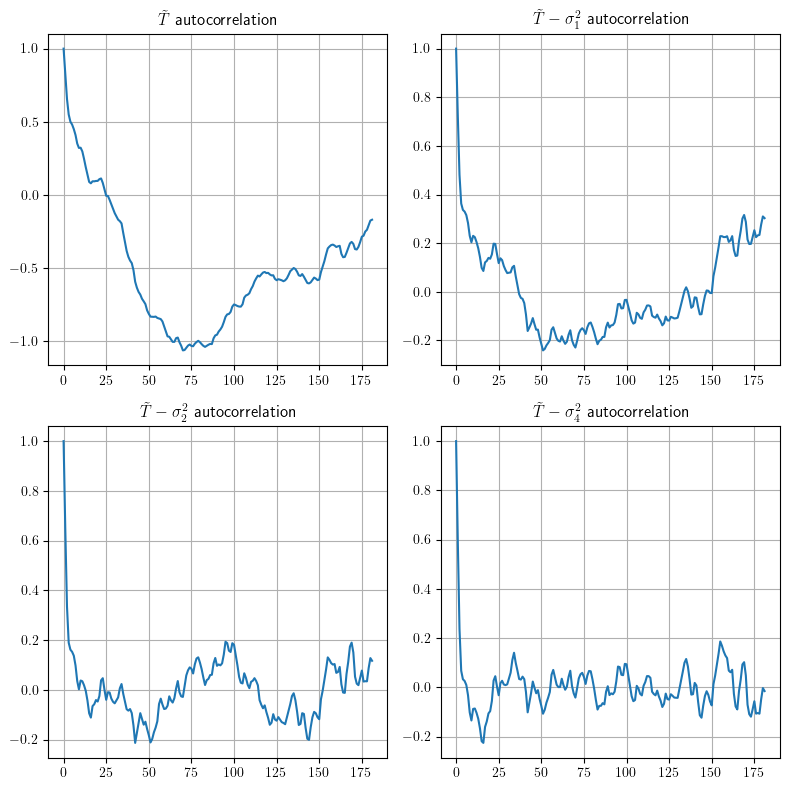

In [78]:
fig, axs = pl.subplots(2, 2, figsize=(8, 8))


axs[0,0].plot(year[0:182], autocorr(avg_vol, 363))
axs[0,0].set_title(r' $\tilde{T}$ autocorrelation')
axs[0,0].grid("True")

axs[0,1].plot(year[0:182], autocorr(avg_vol- sigmasq(year, *sigma_params), 363))
axs[0,1].set_title(r' $\tilde{T}-\sigma^2_1$ autocorrelation')
axs[0,1].grid("True")

axs[1,0].plot(year[0:182], autocorr(avg_vol - sigmasq2(year, *sigma_params2), 363))
axs[1,0].set_title(r' $\tilde{T}-\sigma^2_2$ autocorrelation')
axs[1,0].grid("True")

axs[1,1].plot(year[0:182], autocorr(avg_vol - sigmasq4(year, *sigma_params4), 363))
axs[1,1].set_title(r' $\tilde{T}-\sigma^2_4$ autocorrelation')
axs[1,1].grid("True")

pl.tight_layout()

# Show the plot
pl.show()

In [79]:
fig, axs = pl.subplots(2, 2, figsize=(8, 8))


axs[0,0].hist(autocorr(avg_vol[2:], 363),20)
axs[0,0].set_title(r' $\tilde{T}$ autocorrelation')
axs[0,0].grid("True")

axs[0,1].hist(autocorr(avg_vol- sigmasq(year, *sigma_params), 363)[2:],20)
axs[0,1].set_title(r' $\tilde{T}-\sigma^2_1$ autocorrelation')
axs[0,1].grid("True")

axs[1,0].hist(autocorr(avg_vol - sigmasq2(year, *sigma_params2), 363)[2:],20)
axs[1,0].set_title(r' $\tilde{T}-\sigma^2_2$ autocorrelation')
axs[1,0].grid("True")

axs[1,1].hist(autocorr(avg_vol - sigmasq4(year, *sigma_params4), 363)[2:],20)
axs[1,1].set_title(r' $\tilde{T}-\sigma^2_4$ autocorrelation')
axs[1,1].grid("True")

pl.tight_layout()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [80]:
fig, axs = pl.subplots(2, 2, figsize=(8, 8))


axs[0,0].hist(autocorr(y_deseason[2:], len(y_deseason)-1),20)
axs[0,0].set_title(r' $\tilde{T}$ autocorrelation')
axs[0,0].grid("True")

axs[0,1].hist(autocorr(y_deseason- sigmasq(x, *sigma_params), len(y_deseason)-1)[2:],20)
axs[0,1].set_title(r' $\tilde{T}-\sigma^2_1$ autocorrelation')
axs[0,1].grid("True")

axs[1,0].hist(autocorr(y_deseason - sigmasq2(x, *sigma_params2), len(y_deseason)-1)[2:],20)
axs[1,0].set_title(r' $\tilde{T}-\sigma^2_2$ autocorrelation')
axs[1,0].grid("True")

axs[1,1].hist(autocorr(y_deseason - sigmasq4(x, *sigma_params4), len(y_deseason)-1)[2:],20)
axs[1,1].set_title(r' $\tilde{T}-\sigma^2_4$ autocorrelation')
axs[1,1].grid("True")

pl.tight_layout()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#Accuracy metric for the volatility fitting


[1176.61827557  942.12786626  806.3088852 ]
gain from 1 to 2 0.8007081700360491
gain from 1 to 4 0.6852765267582017


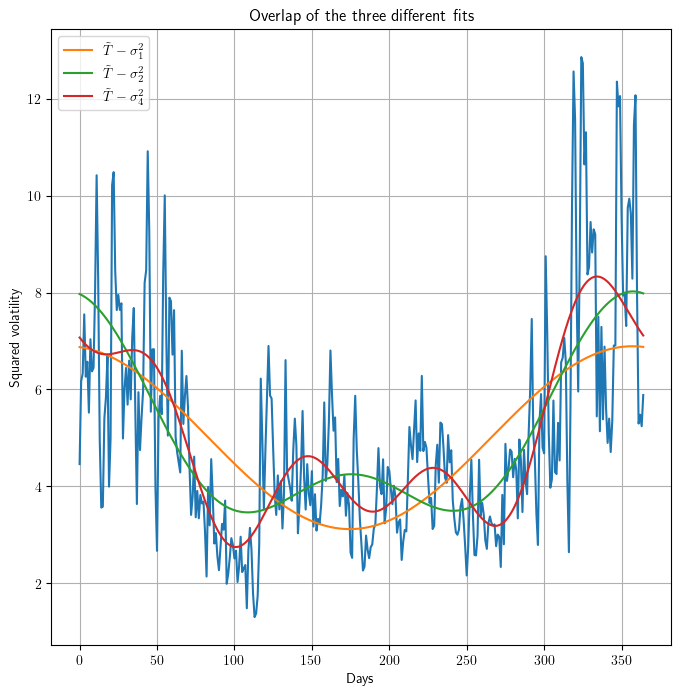

In [81]:
L2_vol = np.zeros(3)


L2_vol[0] = np.sum((avg_vol-sigma_fit_1)**2)
L2_vol[1] = np.sum((avg_vol-sigma_fit_2)**2)
L2_vol[2] = np.sum((avg_vol-sigma_fit_4)**2)

print(L2_vol)
print("gain from 1 to 2", L2_vol[1]/L2_vol[0])
print("gain from 1 to 4", L2_vol[2]/L2_vol[0])


fig, ax = pl.subplots(1, 1, figsize=(8, 8))

ax.plot(year, avg_vol)
ax.plot(year, sigma_fit_1, label=r' $\tilde{T}-\sigma^2_1$')
ax.plot(year, sigma_fit_2, label=r' $\tilde{T}-\sigma^2_2$')
ax.plot(year, sigma_fit_4, label=r' $\tilde{T}-\sigma^2_4$')
ax.set_title("Overlap of the three different fits")
ax.set_xlabel("Days")
ax.set_ylabel("Squared volatility")
ax.grid(True)
ax.legend()
pl.show()


##Fitting the stochastic parameter k



###Maximum likelihood


In [ ]:
def integrand(u,t,k, *params):
  return((sigmasq2(u, *params)) *(np.exp(-2*k*(t-u))))

In [ ]:
def integral(t, k):
  res, err = integrate.quad(integrand, t-1, t, args=(t,k, *sigma_params2))
  return res


In [ ]:
def to_maximize(k):
  sum1 = 0
  sum2 = 0
  sum1 = 0
  for i in range(len(x)-1):
    temp = integral(i, k)
    sum1 = sum1 - 0.5 * np.log(temp)
    sum2 = sum2 + ((y_deseason[i]- np.exp(-k)*y_deseason[i-1])**2)/(2*temp)
    L = sum1 - sum2


  return L


In [ ]:
ig = 0.2  #initial guess set arbitrarily

nwalkers = 8
pos = ig+ 1e0 * np.random.randn(nwalkers,1) #starting positions randomized around the initial guess

pos.shape

(8, 1)

In [ ]:
# #Using emcee to explore the parameter space
sampler = emcee.EnsembleSampler(nwalkers, 1, to_maximize)
sampler.run_mcmc(pos, 100, progress=True); #run the emcee for 20000 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=50, thin=15, flat=True) #throw away burn in phase


100%|██████████| 100/100 [33:15<00:00, 19.95s/it]


In [ ]:
fig, axes = pl.subplots(1, figsize=(6, 3.5), sharex=True)


axes.plot(samples[:,:,0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_title("Markov chains for k (Maximum Likelihood)")
axes.set_xlabel("MC step")
axes.set_ylabel("k")


Text(-0.1, 0.5, 'k')

Result:


In [ ]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True) #throw away burn in phase
results= np.mean(flat_samples[:])   #extract the mean points
k_ML = results
print("Estimation of k using maximum likelihood: k=", k_ML )

Estimation of k using maximum likelihood: k= 0.46793808286295535


###Conditional least squares

In [ ]:
def to_maximize(k):
  sum = 0
  for i in range(len(x)-1):
    sum = sum + (y_deseason[i+1]- np.exp(-k)*y_deseason[i])**2

  return -sum


In [ ]:
ig = 0  #initial guess set to the parameters found by the previous fitting (the idea is to have less burn-in)
#ig = [1,1,1,1,1,1] #uninformed initial guess

nwalkers = 16
pos = ig+ 1e0 * np.random.randn(nwalkers,1) #starting positions randomized around the initial guess

pos.shape

(16, 1)

In [ ]:
# #Using emcee to explore the parameter space
sampler = emcee.EnsembleSampler(nwalkers, 1, to_maximize)
sampler.run_mcmc(pos, 600, progress=True); #run the emcee for 20000 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True) #throw away burn in phase


100%|██████████| 600/600 [08:49<00:00,  1.13it/s]


In [ ]:

results = np.zeros((1,1))
mcmc = np.zeros((1, 3))

mcmc = np.percentile( flat_samples, [16, 50, 84])   #extract the interquartile range and median solution for each parameter
results= np.mean(flat_samples[:])   #extract the mean points
print(results)
print(np.size(results))
print(np.size(mcmc[:]))


0.19906654820704567
1
3


In [ ]:
fig, axes = pl.subplots(1, figsize=(8, 5), sharex=True)


axes.plot(samples[:,:,0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_title("CLS Markov chains for k (Conditional Least Squares)")
axes.set_xlabel("MC step")
axes.set_ylabel("k")


Text(-0.1, 0.5, 'k')

In [ ]:
save2 = 0.19906654820704567
k_CLS= save2

In [ ]:
#Visualise the Markov chains (not ideal)
fig, axes = pl.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
samples = np.squeeze(samples)



axes.plot(samples[:, :], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.yaxis.set_label_coords(-0.1, 0.5)






## Simulation with the estimated parameters


In [87]:
def integrand2(u,t, *params):
  return((sigmasq2(u, *params)) *(np.exp(
      -2*k*(t-u))))

def integral2(t):
  res, err = integrate.quad(integrand2, t-1, t, args=(t, *sigma_params2))
  return res


In [ ]:
k = k_CLS
y_sim = np.zeros(len(x))
for i in range(len(x)-1):
  y_sim[i+1] = np.random.normal(np.exp(-k_CLS)*y_sim[i], np.sqrt(integral2(i)))

y_sim = y_sim + s(x,*params)
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x[1:1700],y_sim[1:1700], label='Simulated process', s = 3.5, color = "red")
ax.plot(x[1:1700],y_fitcomplete[1:1700], 'g-', label='seasonality')
ax.scatter(x[1:1700],y[1:1700], label = "Data", s = 3, color = "blue")
ax.set_title(f"Process simulation k= {k}")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid()

L2_k_2 = np.sum((x-y_sim)**2)
print("L2 metric for this process", L2_k_2)
pl.show()


L2 metric for this process 263462836439.1949


L2 metric for this process 263471477516.7689
comparison with the previous value: L2_ml/L2mcmc:  1.0000327980890618


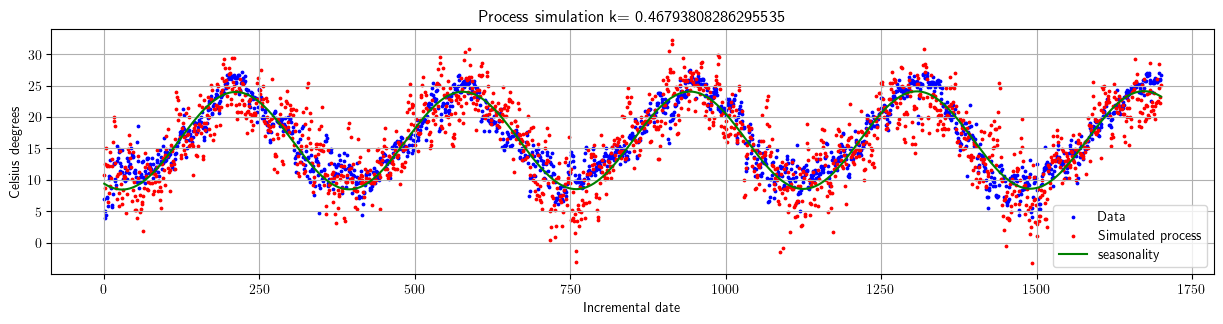

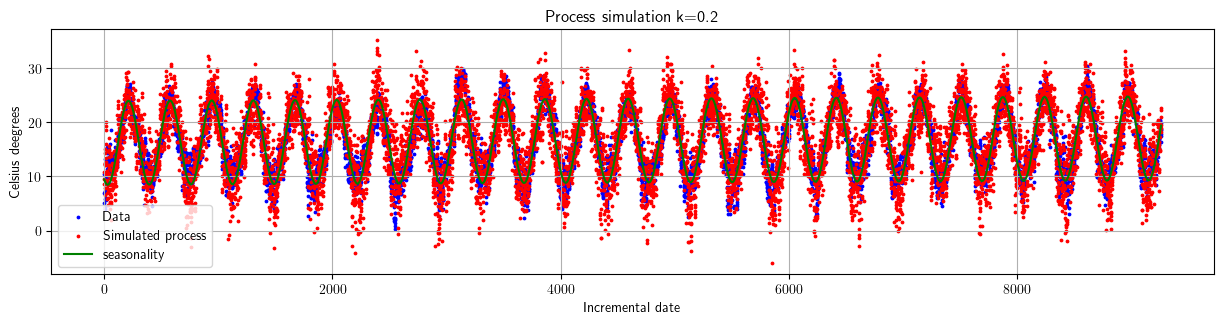

In [ ]:
k=k_ML
#k=results
y_sim2 = np.zeros(len(x))
for i in range(len(x)-1):
  y_sim2[i+1] = np.random.normal(np.exp(-k)*y_sim2[i], np.sqrt(integral2(i)))

y_sim2 = y_sim2 + s(x,*params)


ax = pl.figure(figsize=(15,7)).add_subplot(211)
ax.scatter(x[1:1700],y[1:1700], label = "Data", s=3, color = "blue")
ax.scatter(x[1:1700],y_sim2[1:1700], color = "red", label='Simulated process', s = 3)
ax.plot(x[1:1700],y_fitcomplete[1:1700], 'g-', label='seasonality')
ax.set_title(f"Process simulation k= {k}")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

ax = pl.figure(figsize=(15,7)).add_subplot(212)
ax.scatter(x,y, label = "Data", s=3, color = "blue")
ax.scatter(x,y_sim2, color = "red", label='Simulated process', s = 3)
ax.plot(x,y_fitcomplete, 'g-', label='seasonality')
ax.set_title("Process simulation k=0.2")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

L2_k_02 = np.sum((x-y_sim2)**2)
print("L2 metric for this process", L2_k_02)
print("comparison with the previous value: L2_ml/L2mcmc: ", L2_k_02/L2_k_2)
pl.show()

In [ ]:
k = 0.0
y_sim = np.zeros(len(x))
for i in range(len(x)-1):
  y_sim[i+1] = np.random.normal(np.exp(-k_CLS)*y_sim[i], np.sqrt(integral2(i)))

y_sim = y_sim + s(x,*params)
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(x[1:1700],y_sim[1:1700], label='Simulated process', s = 3.5, color = "red")
ax.plot(x[1:1700],y_fitcomplete[1:1700], 'g-', label='seasonality')
ax.scatter(x[1:1700],y[1:1700], label = "Data", s = 3, color = "blue")
ax.set_title(f"Process simulation k= {k}")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid()



L2_k_0 = np.sum((x-y_sim2)**2)
print("L2 metric for this process", L2_k_0)
print("comparison with the previous value: L2_ml/L2mcmc: ", L2_k_0/L2_k_2)
pl.show()

L2 metric for this process 263471477516.7689
comparison with the previous value: L2_ml/L2mcmc:  1.0000327980890618


Span of multiple values of K in order to see the relation with the L2 metric

In [94]:
L2_span = np.zeros(100)
for j in range(100):
    k=(j/25)-1.9
    y_sim = np.zeros(len(x))
    for i in range(len(x)-1):
        y_sim[i+1] = np.random.normal(np.exp(-k)*y_sim[i], np.sqrt(integral2(i)))
        y_sim = y_sim + s(x,*params)
    L2_span[j] = np.sum((x-y_sim)**2)




<ipython-input-94-c21abeba5382>:6: RuntimeWarning: overflow encountered in double_scalars
  y_sim[i+1] = np.random.normal(np.exp(-k)*y_sim[i], np.sqrt(integral2(i)))
<ipython-input-94-c21abeba5382>:8: RuntimeWarning: overflow encountered in square
  L2_span[j] = np.sum((x-y_sim)**2)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [96]:
pl.plot(np.linspace(-2,2,100), L2_span)

Text(0, 0.5, 'Frequency')

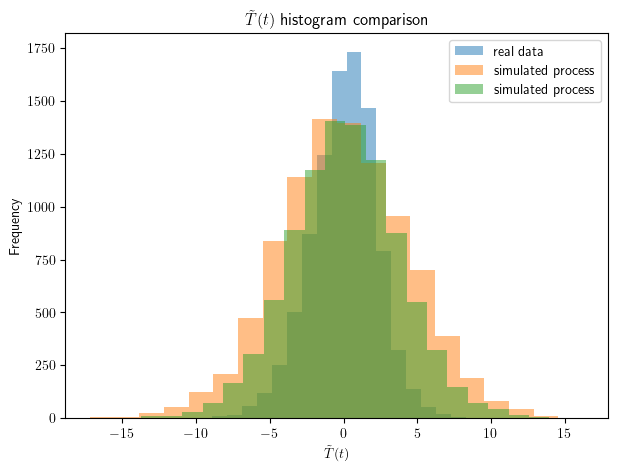

In [ ]:
ax = pl.figure(figsize=(7,5)).add_subplot(111)
ax.hist(y-y_fitcomplete, alpha = 0.5, label = "real data", bins = 20)
ax.hist(y_sim-y_fitcomplete,alpha = 0.5,label = "simulated process", bins = 20)
ax.hist(y_sim2-y_fitcomplete,alpha = 0.5,label = "simulated process", bins = 20)
ax.legend()
ax.set_title(r"$\tilde{T}(t)$ histogram comparison")
ax.set_xlabel(r"$\tilde{T}(t)$")
ax.set_ylabel("Frequency")


#All over with Parma data


In [ ]:
raw_parma = pd.read_excel("Tday 1900-1999.xls")
raw_parma2 = pd.read_excel("Tday 2000-oggi.xls")
raw_parma0 = pd.read_excel("Tday1878-1899.xls")


In [ ]:
print(raw_parma0.columns)
print(raw_parma.columns)
print(raw_parma2.columns)

Index(['Anno', 'Unnamed: 1', 'mese', 'Tmin', 'Tmax', 'Tmed', 'Pioggia', 'Neve',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')
Index(['data', 'gg', 'mese', 'Tmin', 'Tmax', 'Tmed2', 'Precip.', 'Max 1 h',
       'Neve', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')
Index(['data', 'gg', 'mese', 'Tmin', 'Tmax', 'Tmed2', 'Precip.', 'Max 1 h',
       'Neve', 'Vento'],
      dtype='object')


In [ ]:
print(raw_parma0.Anno.unique)
print(raw_parma.data.unique)
print(raw_parma2.data.unique)

<bound method Series.unique of 0        1857
1        1857
2        1857
3        1857
4        1857
         ... 
15396    1899
15397    1899
15398    1899
15399    1899
15400    1899
Name: Anno, Length: 15401, dtype: int64>
<bound method Series.unique of 0       1900-01-01
1       1900-01-02
2       1900-01-03
3       1900-01-04
4       1900-01-05
           ...    
36519   1999-12-27
36520   1999-12-28
36521   1999-12-29
36522   1999-12-30
36523   1999-12-31
Name: data, Length: 36524, dtype: datetime64[ns]>
<bound method Series.unique of 0       2000-01-01
1       2000-01-02
2       2000-01-03
3       2000-01-04
4       2000-01-05
           ...    
33964          NaT
33965          NaT
33966          NaT
33967          NaT
33968          NaT
Name: data, Length: 33969, dtype: datetime64[ns]>


In [ ]:
raw_parma.head()

data  gg mese  Tmin  Tmax  Tmed2  Precip.  Max 1 h Neve  Unnamed: 9  \
0 1900-01-01   1  gen   1.7   4.7   3.20      NaN      NaN  NaN         NaN   
1 1900-01-02   2  gen   1.4   4.8   3.10      0.4      NaN  NaN         NaN   
2 1900-01-03   3  gen   1.9   4.9   3.40      1.9      NaN  NaN         NaN   
3 1900-01-04   4  gen   2.7   6.8   4.75     20.0      NaN  NaN         NaN   
4 1900-01-05   5  gen   2.8   7.2   5.00      3.9      NaN  NaN         NaN   

   Unnamed: 10  Unnamed: 11  Unnamed: 12  Unnamed: 13  Unnamed: 14  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 15              Unnamed: 16  
0          NaN                      NaN  
1          NaN                      NaN  
2          NaN   D = temperatura minima  
3          NaN  E = temperatura massima  
4          NaN    F = temperatura media

In [ ]:
raw_parma2.head()

data   gg mese  Tmin  Tmax  Tmed2 Precip. Max 1 h Neve Vento
0 2000-01-01  1.0  gen  -2.5   5.3   1.40     NaN     NaN  NaN   Max
1 2000-01-02  2.0  gen  -1.6   6.5   2.45     NaN     NaN  NaN   NaN
2 2000-01-03  3.0  gen  -1.7   6.8   2.55     NaN     NaN  NaN   NaN
3 2000-01-04  4.0  gen  -0.3   9.2   4.45     NaN     NaN  NaN   NaN
4 2000-01-05  5.0  gen   0.5   9.6   5.05     NaN     NaN  NaN   NaN

In [ ]:
raw_parma0.head()

Anno  Unnamed: 1      mese  Tmin  Tmax  Tmed Pioggia Neve Unnamed: 8  \
0  1857           1  novembre   NaN   NaN   NaN     NaN  NaN        NaN   
1  1857           2  novembre   NaN   NaN   NaN     NaN  NaN        NaN   
2  1857           3  novembre   NaN   NaN   NaN     NaN  NaN        NaN   
3  1857           4  novembre   NaN   NaN   NaN     NaN  NaN        NaN   
4  1857           5  novembre   NaN   NaN   NaN     NaN  NaN        NaN   

  Unnamed: 9 Unnamed: 10  
0        NaN         NaN  
1        NaN         NaN  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN

In [ ]:
raw_parma0.rename(columns={'Tmed': 'AvgTemperature'}, inplace=True)
raw_parma.rename(columns = {"Tmed2": "AvgTemperature"}, inplace = True)
raw_parma2.rename(columns = {"Tmed2": "AvgTemperature"}, inplace = True)
raw_parma.rename(columns={'data': 'date'}, inplace=True)
raw_parma2.rename(columns={'data': 'date'}, inplace=True)

In [ ]:
print(raw_parma.mese.unique)

<bound method Series.unique of 0        gen
1        gen
2        gen
3        gen
4        gen
        ... 
36519    dic
36520    dic
36521    dic
36522    dic
36523    dic
Name: mese, Length: 36524, dtype: object>


In [ ]:

month_ita = {
    'gennaio': 1,
    'febbraio': 2,
    'marzo': 3,
    'aprile': 4,
    'maggio': 5,
    'giugno': 6,
    'luglio': 7,
    'agosto': 8,
    'settembre': 9,
    'ottobre': 10,
    'novembre': 11,
    'dicembre': 12,
}
#map the month column with the previus function to get the month number
raw_parma0.mese = raw_parma0["mese"].map(month_ita).astype(int)

In [ ]:
#Create the date column using information from the other columns
raw_parma0['date'] = raw_parma0.apply(lambda row: datetime.strptime(f"{row['Anno']} {row['mese']} {row['Unnamed: 1']}", "%Y %m %d"), axis=1)



In [ ]:
#cheching for overlap between last day of one dataframe and the first of the other
raw_parma0.tail()

Anno  Unnamed: 1  mese  Tmin  Tmax  AvgTemperature Pioggia Neve  \
15396  1899          27    12  -0.4   0.4            0.00    10.6   10   
15397  1899          28    12  -2.3   3.0            0.35     NaN  NaN   
15398  1899          29    12  -0.6   1.0            0.20     9.5  NaN   
15399  1899          30    12  -1.7   4.9            1.60     NaN  NaN   
15400  1899          31    12  -1.9   1.5           -0.20     NaN  NaN   

      Unnamed: 8 Unnamed: 9 Unnamed: 10       date  
15396        NaN        NaN         NaN 1899-12-27  
15397        NaN        NaN         NaN 1899-12-28  
15398        NaN        NaN         NaN 1899-12-29  
15399        NaN        NaN         NaN 1899-12-30  
15400        NaN        NaN         NaN 1899-12-31

In [ ]:
raw_parma.head()

date  gg mese  Tmin  Tmax  AvgTemperature  Precip.  Max 1 h Neve  \
0 1900-01-01   1  gen   1.7   4.7            3.20      NaN      NaN  NaN   
1 1900-01-02   2  gen   1.4   4.8            3.10      0.4      NaN  NaN   
2 1900-01-03   3  gen   1.9   4.9            3.40      1.9      NaN  NaN   
3 1900-01-04   4  gen   2.7   6.8            4.75     20.0      NaN  NaN   
4 1900-01-05   5  gen   2.8   7.2            5.00      3.9      NaN  NaN   

   Unnamed: 9  Unnamed: 10  Unnamed: 11  Unnamed: 12  Unnamed: 13  \
0         NaN          NaN          NaN          NaN          NaN   
1         NaN          NaN          NaN          NaN          NaN   
2         NaN          NaN          NaN          NaN          NaN   
3         NaN          NaN          NaN          NaN          NaN   
4         NaN          NaN          NaN          NaN          NaN   

   Unnamed: 14  Unnamed: 15              Unnamed: 16  
0          NaN          NaN                      NaN  
1          NaN          NaN                      NaN  
2          NaN          NaN   D = temperatura minima  
3          NaN          NaN  E = temperatura massima  
4          NaN          NaN    F = temperatura media

In [ ]:
#Only keep the data that will be used
useful_cols = ['date', 'AvgTemperature']
raw_parma = raw_parma[useful_cols]
raw_parma0 = raw_parma0[useful_cols]
raw_parma2 = raw_parma2[useful_cols]


#concatenate the 3 dataframes to have the full time series
raw_Parma = pd.concat([raw_parma0, raw_parma, raw_parma2], ignore_index=True)
print(np.array(raw_Parma.date.unique()))
print("Total number of datapoints: ", raw_Parma.date.unique().size)

['1857-11-01T00:00:00.000000000' '1857-11-02T00:00:00.000000000'
 '1857-11-03T00:00:00.000000000' ... '2023-02-27T00:00:00.000000000'
 '2023-02-28T00:00:00.000000000'                           'NaT']
Total number of datapoints:  60386


In [ ]:
condition = (raw_Parma['date'].dt.month == 2) & (raw_Parma['date'].dt.day == 29)
raw_Parma = raw_Parma[~condition].reset_index(drop=True)

In [ ]:
#converting to Datetime objects and discarding the start of 2023
raw_Parma['date'] = pd.to_datetime(raw_Parma["date"], yearfirst = True)
raw_Parma = raw_Parma[raw_Parma["date"]<datetime(2023,1,1)]

In [ ]:
raw_Parma

date  AvgTemperature
0     1857-11-01             NaN
1     1857-11-02             NaN
2     1857-11-03             NaN
3     1857-11-04             NaN
4     1857-11-05             NaN
...          ...             ...
60281 2022-12-27           10.10
60282 2022-12-28            8.90
60283 2022-12-29            8.85
60284 2022-12-30            8.80
60285 2022-12-31           10.00

[60286 rows x 2 columns]

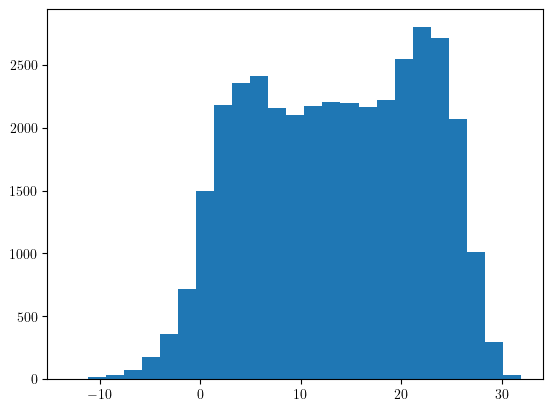

In [ ]:
pl.hist(raw_parma["AvgTemperature"],25);


In [ ]:
print(raw_Parma.isna().sum())
raw_Parma.dropna(subset=['AvgTemperature'], inplace=True)
print(raw_Parma.isna().sum())

date                 0
AvgTemperature    7361
dtype: int64
date              0
AvgTemperature    0
dtype: int64


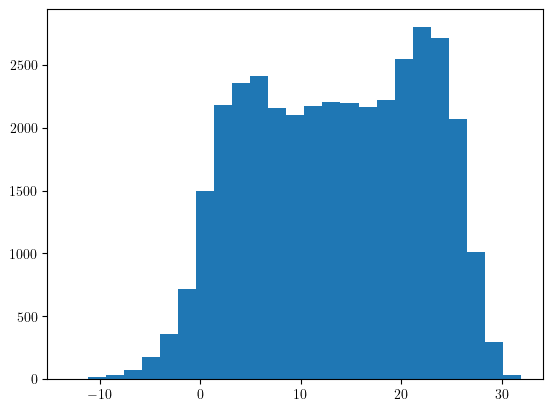

In [ ]:
pl.hist(raw_parma["AvgTemperature"],25);


In [ ]:
start_date_parma = raw_Parma.date.min()
raw_Parma["IncrementalDate"]=(raw_Parma["date"] - start_date_parma).dt.days
parma_x = np.array(raw_Parma["IncrementalDate"])
parma_y = np.array(raw_Parma["AvgTemperature"])

In [ ]:
raw_Parma

date  AvgTemperature  IncrementalDate
7361  1878-01-01            2.10                0
7362  1878-01-02            3.60                1
7363  1878-01-03            0.20                2
7364  1878-01-04           -1.35                3
7365  1878-01-05           -2.40                4
...          ...             ...              ...
60281 2022-12-27           10.10            52955
60282 2022-12-28            8.90            52956
60283 2022-12-29            8.85            52957
60284 2022-12-30            8.80            52958
60285 2022-12-31           10.00            52959

[52925 rows x 3 columns]

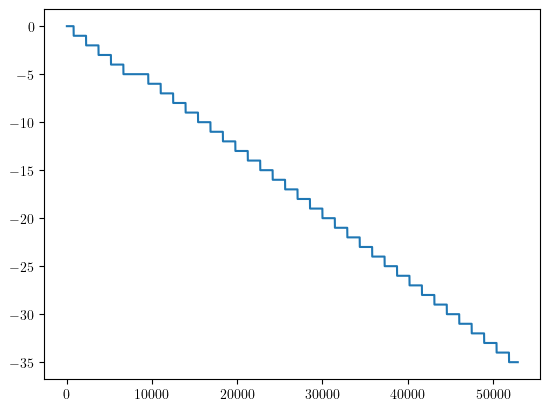

In [ ]:
#if some date are missing I would see a different value from 0
pl.plot(np.arange(len(parma_x))-parma_x)

In [ ]:
raw_Parma

date  AvgTemperature  IncrementalDate
7361  1878-01-01            2.10                0
7362  1878-01-02            3.60                1
7363  1878-01-03            0.20                2
7364  1878-01-04           -1.35                3
7365  1878-01-05           -2.40                4
...          ...             ...              ...
60281 2022-12-27           10.10            52955
60282 2022-12-28            8.90            52956
60283 2022-12-29            8.85            52957
60284 2022-12-30            8.80            52958
60285 2022-12-31           10.00            52959

[52925 rows x 3 columns]

##Fitting the whole s for Parma data


In [ ]:
def s(t, a0, a1, b, b1, f, g):
    return a0 + b*t + a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)

parma_params, parma_cov = curve_fit(s, parma_x, parma_y)
parma_perr_complete = np.sqrt(np.diag(parma_cov))

y_fit_parma = s(parma_x, *parma_params)

# Plot the original data and the fitted function
fig, axs = pl.subplots(3, 1, figsize=(15, 10))
axs[0].scatter(parma_x,parma_y, label = "Data", s=2)
axs[0].plot(parma_x,y_fit_parma, 'r-', label='Fitted Function')
axs[0].set_title("Complete seasonality fit for Parma data")
axs[0].set_ylabel("Celsius deegrees")
axs[0].set_xlabel("Incremental date")
axs[0].legend()
axs[0].grid(True)

axs[1].title.set_position([.5, 5.95])
axs[1].scatter(parma_x[0:2000],parma_y[0:2000], label = "Data", s=2)
axs[1].plot(parma_x[0:2000],y_fit_parma[0:2000], 'r-', label='Fitted Function')
axs[1].set_title("First 2000 days")
axs[1].set_ylabel("Celsius deegrees")
axs[1].set_xlabel("Incremental date")
axs[1].legend()
axs[1].grid(True)
fig.subplots_adjust(hspace=0.5)


axs[2].title.set_position([.5, 1.95])
axs[2].scatter(parma_x[-2000:],parma_y[-2000:], label = "Data", s=2)
axs[2].plot(parma_x[-2000:],y_fit_parma[-2000:], 'r-', label='Fitted Function')
axs[2].set_title("Last 2000 days")
axs[2].set_ylabel("Celsius deegrees")
axs[2].set_xlabel("Incremental date")
axs[2].legend()
axs[2].grid(True)

print("Parameters obtained:")
print("a0: ", parma_params[0], "+/-", parma_perr_complete[0])
print("a1: ", parma_params[1], "+/-", parma_perr_complete[1])
print("b0: ", parma_params[2], "+/-", parma_perr_complete[2])
print("b1: ", parma_params[3], "+/-", parma_perr_complete[3])
print("f: ", parma_params[4], "+/-", parma_perr_complete[4])
print("g: ", parma_params[5], "+/-", parma_perr_complete[5])

Parameters obtained:
a0:  12.451326380734733 +/- 0.028399850410064126
a1:  -11.05841870261246 +/- 4582.4819270022745
b0:  4.7443928188595584e-05 +/- 9.288371622398093e-07
b1:  -1.4214530845762332 +/- 4211.723281594406
f:  51.11257149624885 +/- 22101.78598409538
g:  52.7679700203832 +/- 187111.3512674338


In [ ]:
print("The trend sees the temperature growing of 1C every {0:2.2f} years".format(1/(parma_params[2]*365)))

The trend sees the temperature growing of 1C every 57.75 years


In [ ]:
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(parma_x[30000:35000],parma_y[30000:35000], label = "Data", s=2)
ax.plot(parma_x[30000:35000],y_fit_parma[30000:35000], 'r-', label='Fitted Function')
ax.set_title("Complete seasonality fit for Parma data(Zoom)")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date from 1st jan 1900")
ax.legend()
ax.grid(True)

###splitting the time period in 4 subsets

In [ ]:
parma_split1x = parma_x[0:10500]
parma_split1y = parma_y[0:10500]
parma_split2x = parma_x[10500:21000]
parma_split2y = parma_y[10500:21000]
parma_split3x = parma_x[21000:31500]
parma_split3y = parma_y[21000:31500]
parma_split4x = parma_x[31500:42000]
parma_split4y = parma_y[31500:42000]
parma_split5x = parma_x[42000:]
parma_split5y = parma_y[42000:]


parma_params_split1, parma_cov_split1 = curve_fit(s, parma_split1x, parma_split1y)
parma_perr_complete_split1 = np.sqrt(np.diag(parma_cov_split1))
y_fit_parma_split1 = s(parma_split1x, *parma_params_split1)

parma_params_split2, parma_cov_split2 = curve_fit(s, parma_split2x, parma_split2y)
parma_perr_complete_split2 = np.sqrt(np.diag(parma_cov_split2))
y_fit_parma_split2 = s(parma_split2x, *parma_params_split2)

parma_params_split3, parma_cov_split3 = curve_fit(s, parma_split3x, parma_split3y)
parma_perr_complete_split3 = np.sqrt(np.diag(parma_cov_split3))
y_fit_parma_split3 = s(parma_split3x, *parma_params_split3)

parma_params_split4, parma_cov_split4 = curve_fit(s, parma_split4x, parma_split4y)
parma_perr_complete_split4 = np.sqrt(np.diag(parma_cov_split4))
y_fit_parma_split4 = s(parma_split4x, *parma_params_split4)

parma_params_split5, parma_cov_split5 = curve_fit(s, parma_split5x, parma_split5y)
parma_perr_complete_split5 = np.sqrt(np.diag(parma_cov_split5))
y_fit_parma_split5 = s(parma_split5x, *parma_params_split5)


print("Split1 trend: 1C every {0:2.2f} years".format(1/(parma_params_split1[2]*365)))
print("Split1 trend: 1C every {0:2.2f} years".format(1/(parma_params_split2[2]*365)))
print("Split1 trend: 1C every {0:2.2f} years".format(1/(parma_params_split3[2]*365)))
print("Split1 trend: 1C every {0:2.2f} years".format(1/(parma_params_split4[2]*365)))
print("Split1 trend: 1C every {0:2.2f} years".format(1/(parma_params_split5[2]*365)))

Split1 trend: 1C every 32.04 years
Split1 trend: 1C every 48.48 years
Split1 trend: 1C every 532.81 years
Split1 trend: 1C every -562.22 years
Split1 trend: 1C every 20.53 years


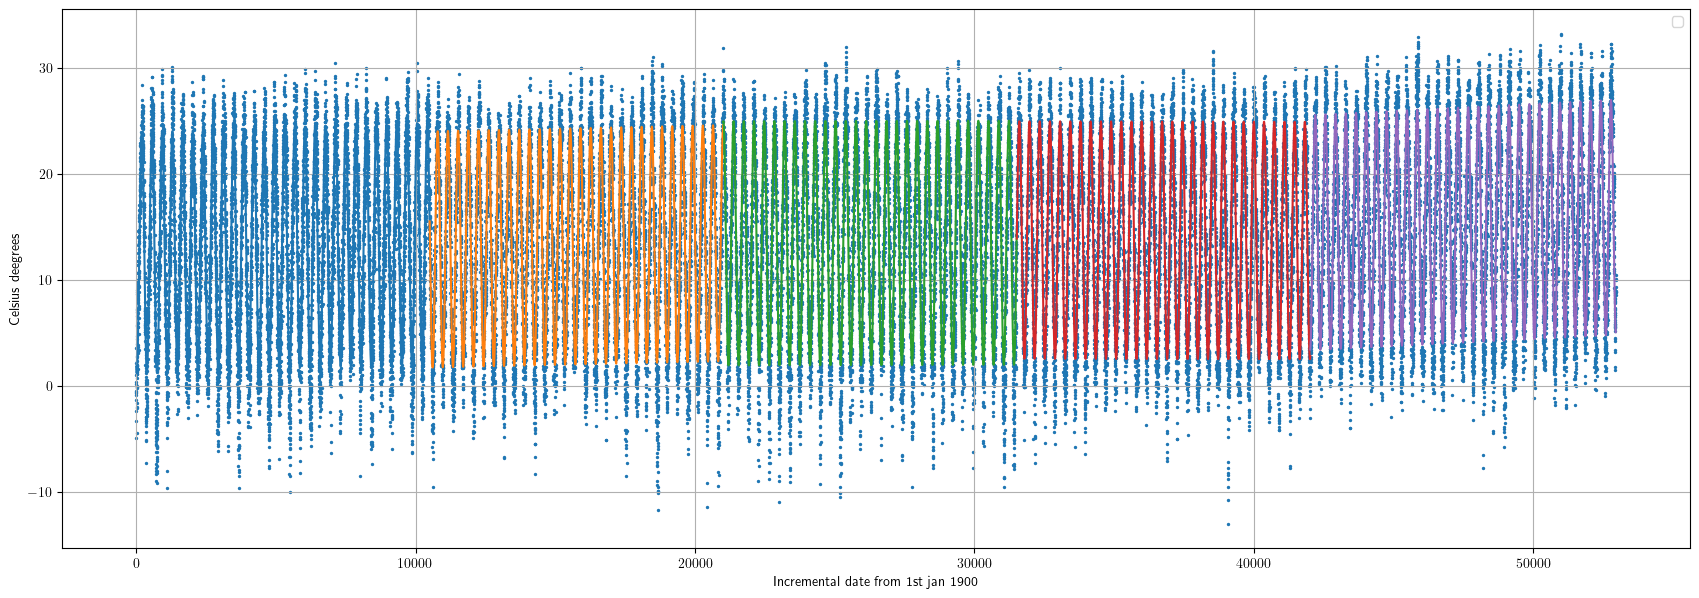

In [ ]:
ax = pl.figure(figsize=(21,7)).add_subplot(111)
ax.plot(parma_split1x, y_fit_parma_split1)
ax.plot(parma_split2x, y_fit_parma_split2)
ax.plot(parma_split3x, y_fit_parma_split3)
ax.plot(parma_split4x, y_fit_parma_split4)
ax.plot(parma_split5x, y_fit_parma_split5)
ax.scatter(parma_x,parma_y, s=2)
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date from 1st jan 1900")
ax.legend()
ax.grid(True)


###exponential trend

In [ ]:
def s_exp(t, a0, a1, b, b1, f, g):
    return a0 + t**b + a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)

parma_params_exp, parma_cov_exp = curve_fit(s, parma_x, parma_y)
parma_perr_complete_exp = np.sqrt(np.diag(parma_cov_exp))

y_fit_parma_exp = s(parma_x, *parma_params_exp)

# Plot the original data and the fitted function
fig, axs = pl.subplots(3, 1, figsize=(15, 10))
axs[0].scatter(parma_x,parma_y, label = "Data", s=2)
axs[0].plot(parma_x,y_fit_parma_exp, 'r-', label='Fitted Function')
axs[0].set_title("Complete seasonality fit for Parma data")
axs[0].set_ylabel("Celsius deegrees")
axs[0].set_xlabel("Incremental date")
axs[0].legend()
axs[0].grid(True)

axs[1].title.set_position([.5, 5.95])
axs[1].scatter(parma_x[0:2000],parma_y[0:2000], label = "Data", s=2)
axs[1].plot(parma_x[0:2000],y_fit_parma_exp[0:2000], 'r-', label='Fitted Function')
axs[1].set_title("First 2000 days")
axs[1].set_ylabel("Celsius deegrees")
axs[1].set_xlabel("Incremental date")
axs[1].legend()
axs[1].grid(True)
fig.subplots_adjust(hspace=0.5)


axs[2].title.set_position([.5, 1.95])
axs[2].scatter(parma_x[-2000:],parma_y[-2000:], label = "Data", s=2)
axs[2].plot(parma_x[-2000:],y_fit_parma_exp[-2000:], 'r-', label='Fitted Function')
axs[2].set_title("Last 2000 days")
axs[2].set_ylabel("Celsius deegrees")
axs[2].set_xlabel("Incremental date")
axs[2].legend()
axs[2].grid(True)

print("Parameters obtained:")
print("a0: ", parma_params_exp[0], "+/-", parma_perr_complete_exp[0])
print("a1: ", parma_params_exp[1], "+/-", parma_perr_complete_exp[1])
print("b0: ", parma_params_exp[2], "+/-", parma_perr_complete_exp[2])
print("b1: ", parma_params_exp[3], "+/-", parma_perr_complete_exp[3])
print("f: ", parma_params_exp[4], "+/-", parma_perr_complete_exp[4])
print("g: ", parma_params_exp[5], "+/-", parma_perr_complete_exp[5])


Parameters obtained:
a0:  12.451326380734733 +/- 0.028399850410064126
a1:  -11.05841870261246 +/- 4582.4819270022745
b0:  4.7443928188595584e-05 +/- 9.288371622398093e-07
b1:  -1.4214530845762332 +/- 4211.723281594406
f:  51.11257149624885 +/- 22101.78598409538
g:  52.7679700203832 +/- 187111.3512674338


In [ ]:
y_trend = parma_params[0] + parma_params[2]*parma_x
y_trend_split = 0
y_trend_exp = parma_params_exp[0] + parma_x**parma_params[2]


ax = pl.figure(figsize=(15,7)).add_subplot(111)

ax.scatter(parma_x,parma_y, label = "Data", s=2)
ax.plot(parma_x,y_trend, 'r-', label='linear trend')
ax.plot(parma_x,y_trend_exp, 'm-', label='exponential trend')

ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

###More modes in the Fourier expantion

In [ ]:
def s_4modes(t, a0, a1, a2 , b, b1, b2, f1, f2,  g1, g2):
    return a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365) + b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)

def s_6modes(t, a0, a1, a2, a3, b, b1, b2, b3,  f1, f2, f3,  g1, g2, g3):
    return (a0 + b*t + a1 * np.sin(2*np.pi*(t+f1)/365)+ a2 * np.sin(4*np.pi*(t+f2)/365)+ a3 * np.sin(6*np.pi*(t+f3)/365) + \
     b1 * np.cos(2*np.pi*(t+g1)/365)+ b2 * np.cos(4*np.pi*(t+g2)/365)+ b3 * np.cos(6*np.pi*(t+g3)/365))



parma_params_6modes, parma_cov_6modes = curve_fit(s_6modes, parma_x, parma_y)
parma_perr_6modes = np.sqrt(np.diag(parma_cov_6modes))


y_fit_parma_6modes = s_6modes(parma_x, *parma_params_6modes)

# Plot the original data and the fitted function
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(parma_x[0:2000],parma_y[0:2000], label = "Data", s=2)
ax.plot(parma_x[0:2000],y_fit_parma_6modes[0:2000], 'r-', label='6 modes')
ax.plot(parma_x[0:2000],y_fit_parma[0:2000], 'm-', label='2 modes')
ax.set_title("Truncation to three sines and three cosines")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)



##MonteCarlo parma seasonality

In [ ]:
ig = parma_params  #initial guess set to the parameters found by the previous fitting (the idea is to have less burn-in)
#ig = [1,1,1,1,1,1] #uninformed initial guess
ndim = len(ig)
nwalkers = 16
pos = np.array(ig)+ 1 * np.random.randn(nwalkers,ndim) #starting positions randomized around the initial guess

pos.shape

(16, 6)

In [ ]:
def log_probability(theta, x, y):
  #since there is no prior the probability is the likelihood
  return log_likelihood(theta,x,y)

def log_likelihood(theta, x, y):
  a0,a1,b,b1,f,g = theta
  #set the likelihood as the sum of the squared residuals
  return -np.sum((y-s(x, *theta))**2)


#Using emcee to explore the parameter space
np.random.seed(225)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(parma_x, parma_y))
sampler.run_mcmc(pos, 20000, progress=True); #run the emcee for 20000 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=1500, thin=15, flat=True) #throw away burn in phase




  1%|          | 104/20000 [00:07<30:14, 10.96it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-34-44ceaee8bbe5>", line 3, in log_probability
    return log_likelihood(theta,x,y)
  File "<ipython-input-34-44ceaee8bbe5>", line 8, in log_likelihood
    return -np.sum((y-s(x, *theta))**2)
  File "<ipython-input-29-f6cd27edd196>", line 2, in s
    return a0 + b*t + a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)
KeyboardInterrupt
  1%|          | 104/20000 [00:07<24:30, 13.53it/s]


emcee: Exception while calling your likelihood function:
  params: [ 1.25313528e+01 -1.19335060e+01  4.46416341e-05  1.93931291e+00
  6.72831243e+01  4.14759630e+01]
  args: (array([    0,     1,     2, ..., 52957, 52958, 52959]), array([ 2.1 ,  3.6 ,  0.2 , ...,  8.85,  8.8 , 10.  ]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:

results = np.zeros((ndim,1))
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])   #extract the interquartile range and median solution for each parameter
  results[i] = np.mean(flat_samples[:,i])   #extract the mean points
print(results)
print(np.size(results))
print(np.size(mcmc[:,1]))


In [ ]:
results = [ 1.24523126e+01,
  -1.09261144e+01,
  4.74151306e-05,
 -3.65181689e+00,
  3.94157717e+01,
  4.42460400e+01]

In [ ]:
#triangle plot to visualize the parameter distributions (something broken?)
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a0","a1","b","b1","f","g"], truths=mcmc[:,1]);

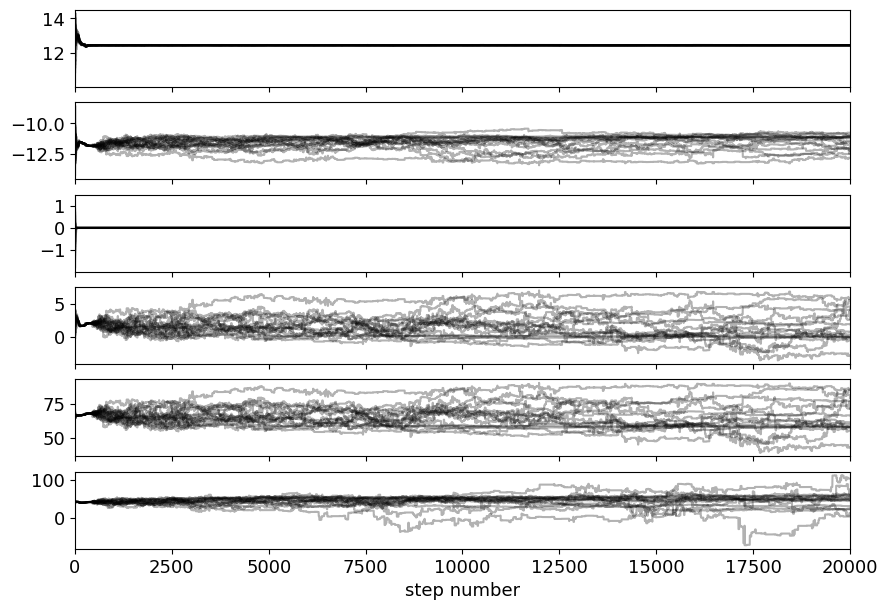

In [ ]:
#Visualise the Markov chains (not ideal)
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

565084.0688205764
565472.1699935652


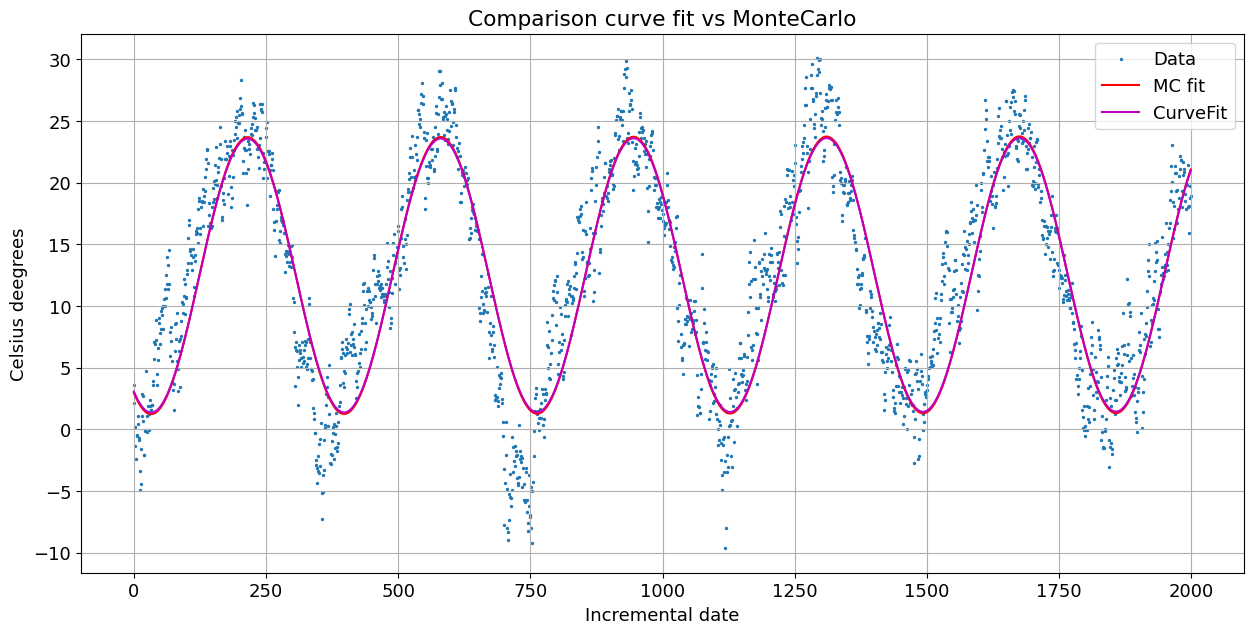

In [ ]:
y_MC_parma = s(parma_x,*results)
# Plot the original data and the fitted function
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.scatter(parma_x[0:2000],parma_y[0:2000], label = "Data", s=2)
ax.plot(parma_x[0:2000],y_MC_parma[0:2000], 'r-', label='MC fit')
ax.plot(parma_x[0:2000],y_fit_parma[0:2000], 'm-', label='CurveFit')
ax.set_title("Comparison curve fit vs MonteCarlo")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)


L2_cf = np.sum((y_fit_parma-parma_y)**2)
L2_MC = np.sum((y_MC_parma-parma_y)**2)
print(L2_cf)
print(L2_MC)

##Parma volatilty

In [ ]:
parma_deseason = parma_y - y_fit_parma

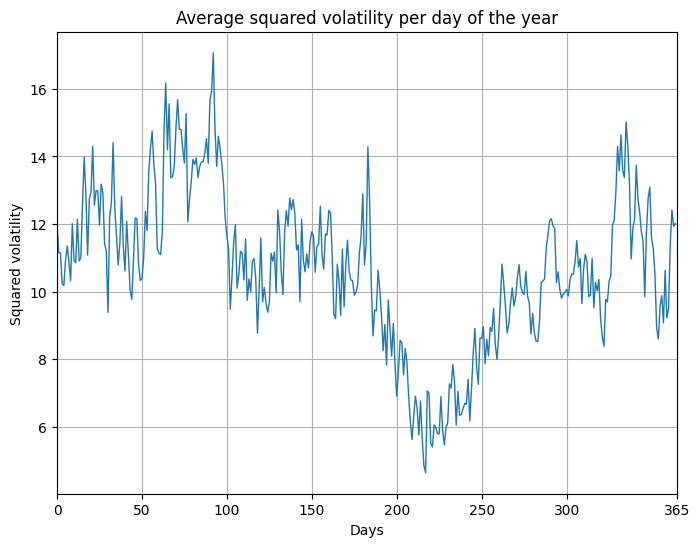

In [ ]:
parma_avg_vol = np.zeros(365)
n_years = np.zeros(365)
year = np.arange(365)



for i in range(len(parma_x)):
  for j in range(365):
    if i % 365 == j:
      parma_avg_vol[j]= parma_avg_vol[j] + parma_deseason[i]**2
      n_years[j]= n_years[j]+1

for j in range(365):
  parma_avg_vol[j] = parma_avg_vol[j]/n_years[j]




fig, ax = pl.subplots(figsize = (8,6))

ax.plot(year,parma_avg_vol, linewidth = 1)

ax.grid(True)
ax.set_title("Average squared volatility per day of the year")
ax.set_xlabel("Days")
ax.set_xlim([0,365])
ax.set_xticks([0,50,100,150,200,250,300,365])
ax.set_ylabel("Squared volatility");

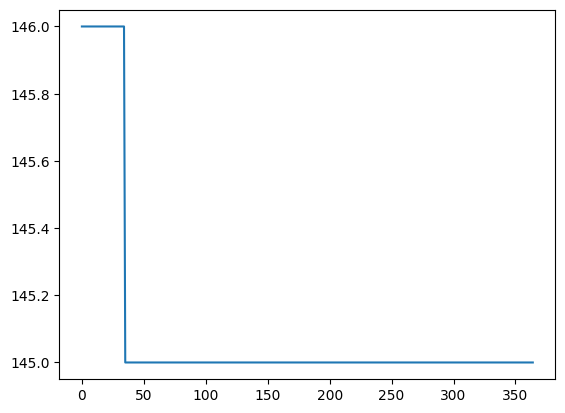

In [ ]:
pl.plot(n_years)

In [ ]:
def sigmasq(t, c, c1, d1):
  return (c + c1*np.sin((2*np.pi*t)/(365)) + d1*np.cos((2*np.pi*t)/(365)))

def sigmasq2(t,c,c1,c2,d1,d2):
  return (c+ c1*np.sin((2*np.pi*t)/(365))+ c2*np.sin((4*np.pi*t)/(365))+\
  d1*np.cos((2*np.pi*t)/(365))+ d2*np.cos((4*np.pi*t)/(365)))

def sigmasq4(t, c, c1,c2,c3,c4, d1,d2,d3,d4):
  return (c+ c1*np.sin((2*np.pi*t)/(365))+ c2*np.sin((4*np.pi*t)/(365))+ c3*np.sin((6*np.pi*t)/(365))+ c4*np.sin((8*np.pi*t)/(365))+\
  d1*np.cos((2*np.pi*t)/(365))+ d2*np.cos((4*np.pi*t)/(365))+ d3*np.cos((6*np.pi*t)/(365))+ d4*np.cos((8*np.pi*t)/(365)))



In [ ]:
parma_sigma1_params, parma_sigma1_cov = curve_fit(sigmasq, year, parma_avg_vol)
parma_sigma_fit_1 = sigmasq(year, *parma_sigma1_params);

print(parma_sigma1_params)
print(np.diagonal(parma_sigma1_cov))

[10.66919577  1.85142415  1.44234511]
[0.00698021 0.01396043 0.01396043]


In [ ]:
parma_sigma2_params, parma_sigma2_cov = curve_fit(sigmasq2, year, parma_avg_vol)
parma_sigma_fit_2 = sigmasq2(year, *parma_sigma2_params);

print(parma_sigma2_params)
print(np.diagonal(parma_sigma2_cov))

[10.66919577  1.85142414 -0.76619429  1.4423451  -0.32917834]
[0.00605314 0.01210628 0.01210628 0.01210628 0.01210628]


In [ ]:
parma_sigma4_params, parma_sigma4_cov = curve_fit(sigmasq4, year, parma_avg_vol)
parma_sigma_fit_4 = sigmasq4(year, *parma_sigma4_params);

print(parma_sigma4_params)
print(np.diagonal(parma_sigma4_cov))

[10.66919577  1.85142415 -0.76619428  0.23960838 -0.63770635  1.44234511
 -0.32917838 -0.77142423  0.62873386]
[0.00407834 0.00815668 0.00815668 0.00815668 0.00815668 0.00815668
 0.00815668 0.00815668 0.00815668]


[922.2955347  795.38283205 529.9396578 ]
0.8623947553956189
0.5745876867709314


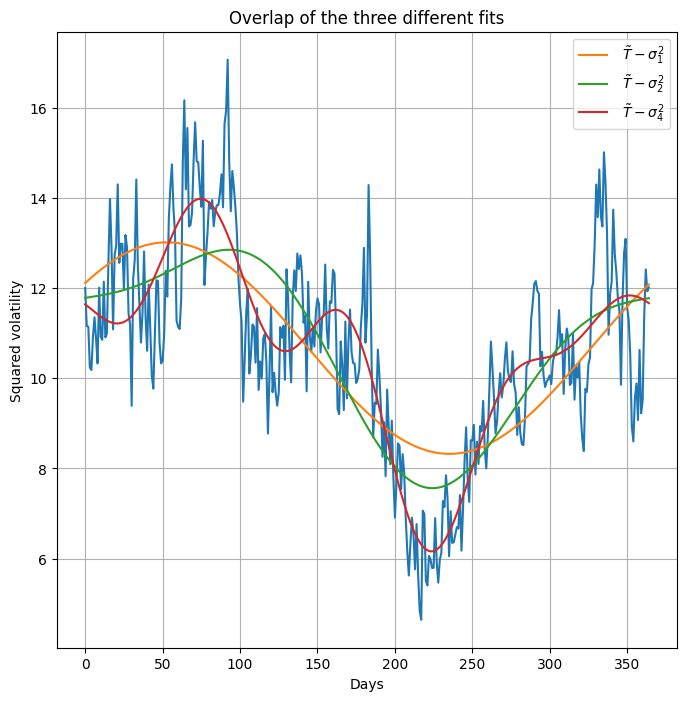

In [ ]:
L2_vol_parma = np.zeros(3)


L2_vol_parma[0] = np.sum((parma_avg_vol-parma_sigma_fit_1)**2)
L2_vol_parma[1] = np.sum((parma_avg_vol-parma_sigma_fit_2)**2)
L2_vol_parma[2] = np.sum((parma_avg_vol-parma_sigma_fit_4)**2)


print(L2_vol_parma)
print(L2_vol_parma[1]/L2_vol_parma[0])
print(L2_vol_parma[2]/L2_vol_parma[0])


fig, ax = pl.subplots(1, 1, figsize=(8, 8))

ax.plot(year, parma_avg_vol)
ax.plot(year, parma_sigma_fit_1, label=r' $\tilde{T}-\sigma^2_1$')
ax.plot(year, parma_sigma_fit_2, label=r' $\tilde{T}-\sigma^2_2$')
ax.plot(year, parma_sigma_fit_4, label=r' $\tilde{T}-\sigma^2_4$')
ax.set_title("Overlap of the three different fits")
ax.set_xlabel("Days")
ax.set_ylabel("Squared volatility")
ax.grid(True)
ax.legend()


In [ ]:
def autocorr(vector, T):
    cc = np.ones(T)
    for t in range(T):
      cc[t] = np.mean(vector[0:(T-t-1)] * vector[t:(T-1)])

    cc = cc - np.mean(vector)**2
    cc = cc/cc[0]

    if T >= len(vector)/2:
      return cc[0:round(len(vector)/2)]
    else:
      return cc


fig, axs = pl.subplots(2, 2, figsize=(8, 8))


axs[0,0].plot(year[0:182], autocorr(parma_avg_vol, 363))
axs[0,0].set_title(r' $\tilde{T}$ autocorrelation')
axs[0,0].grid("True")

axs[0,1].plot(year[0:182], autocorr(parma_avg_vol- sigmasq(year, *parma_sigma1_params), 363))
axs[0,1].set_title(r' $\tilde{T}-\sigma^2_1$ autocorrelation')
axs[0,1].grid("True")

axs[1,0].plot(year[0:182], autocorr(parma_avg_vol - sigmasq2(year, *parma_sigma2_params), 363))
axs[1,0].set_title(r' $\tilde{T}-\sigma^2_2$ autocorrelation')
axs[1,0].grid("True")

axs[1,1].plot(year[0:182], autocorr(parma_avg_vol - sigmasq4(year, *parma_sigma4_params), 363))
axs[1,1].set_title(r' $\tilde{T}-\sigma^2_4$ autocorrelation')
axs[1,1].grid("True")

pl.tight_layout()

# Show the plot
pl.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


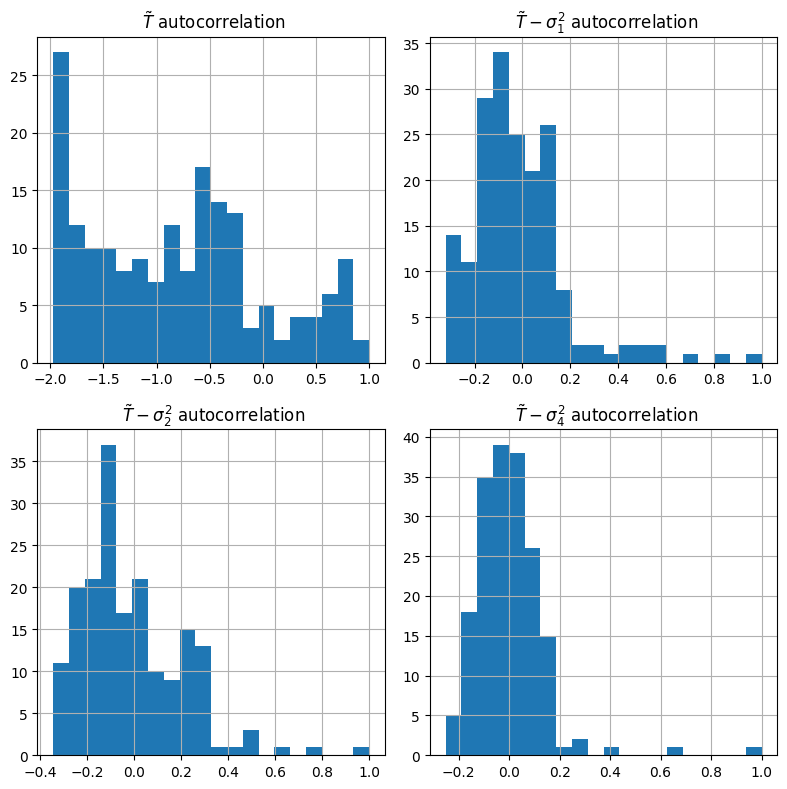

In [ ]:
fig, axs = pl.subplots(2, 2, figsize=(8, 8))


axs[0,0].hist(autocorr(parma_avg_vol, 363),20)
axs[0,0].set_title(r' $\tilde{T}$ autocorrelation')
axs[0,0].grid("True")

axs[0,1].hist( autocorr(parma_avg_vol- sigmasq(year, *parma_sigma1_params), 363),20)
axs[0,1].set_title(r' $\tilde{T}-\sigma^2_1$ autocorrelation')
axs[0,1].grid("True")

axs[1,0].hist( autocorr(parma_avg_vol - sigmasq2(year, *parma_sigma2_params), 363),20)
axs[1,0].set_title(r' $\tilde{T}-\sigma^2_2$ autocorrelation')
axs[1,0].grid("True")

axs[1,1].hist( autocorr(parma_avg_vol - sigmasq4(year, *parma_sigma4_params), 363),20)
axs[1,1].set_title(r' $\tilde{T}-\sigma^2_4$ autocorrelation')
axs[1,1].grid("True")

pl.tight_layout()

# Show the plot
pl.show()

##Estimaiton of k for Parma


In [ ]:
def p_integral(t):
  res, err = integrate.quad(p_integrand, t-1, t, args=(t, *parma_sigma2_params))
  return res

def p_integrand(u,t, *params):
  return((sigmasq2(u, *params)) *(np.exp(-2*(t-u))))

In [ ]:
f1=0
f2=0
acc = np.zeros(len(parma_x))
for i in range(len(parma_x)):
  f1 = f1 + 0.5*np.log(p_integral(i+1))
  acc[i] = acc[i-1] + f1
  f2 = f2 + (parma_deseason[i])/(p_integral(i+1))

k = 0.5*np.log(f1/f2)

<ipython-input-52-b4155c73a16b>:9: RuntimeWarning: invalid value encountered in log
  k = 0.5*np.log(f1/f2)


In [ ]:
k


nan

Conditional Least Squares

In [ ]:
def p_to_maximize(k):
  sum = 0
  for i in range(len(parma_x)-1):
    sum = sum + (parma_deseason[i+1]- np.exp(-k)*parma_deseason[i])**2

  return -sum


In [ ]:
ig = 0.5  #initial guess set to the parameters found by the previous fitting (the idea is to have less burn-in)
#ig = [1,1,1,1,1,1] #uninformed initial guess

nwalkers = 16
pos = ig+ 1e-4 * np.random.randn(nwalkers,1) #starting positions randomized around the initial guess

pos.shape

(16, 1)

In [ ]:
# #Using emcee to explore the parameter space
sampler = emcee.EnsembleSampler(nwalkers, 1, p_to_maximize)
sampler.run_mcmc(pos, 200, progress=True); #run the emcee for 600 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True) #throw away burn in phase


100%|██████████| 200/200 [17:38<00:00,  5.29s/it]


In [ ]:
results = np.zeros((1,1))
mcmc = np.zeros((1, 3))

mcmc = np.percentile( flat_samples, [16, 50, 84])   #extract the interquartile range and median solution for each parameter
results= np.mean(flat_samples[:])   #extract the mean points
print(results)
print(np.size(results))
print(np.size(mcmc[:]))


0.17100329445985926
1
3


In [ ]:
#Visualise the Markov chains (not ideal)
fig, axes = pl.subplots(1, figsize=(7, 4), sharex=True)
samples = sampler.get_chain()
samples = np.squeeze(samples)



axes.plot(samples[:, :], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_title("MCMC paths for k estimation")
axes.set_xlabel("step number")
axes.set_ylabel("k")





SyntaxError: invalid syntax (<ipython-input-57-05c1121297b9>, line 14)

###Simulation for Parma

L2 metric for this process 49472657280681.12


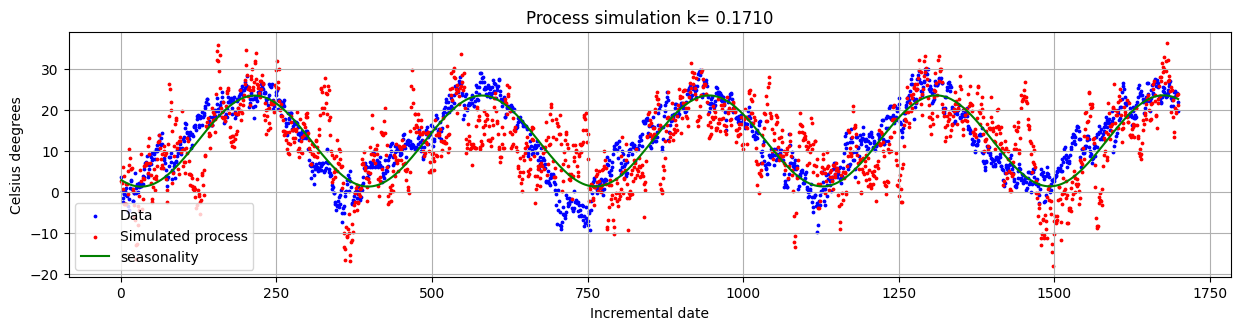

In [ ]:
def integrand2_p(u,t, *params):
  return((sigmasq2(u, *params)) *(np.exp(2*k*(t-u))))

def integral2_p(t):
  res, err = integrate.quad(integrand2_p, t-1, t, args=(t, *parma_sigma2_params))
  return res


k=0.17100329445985926
y_sim_parma = np.zeros(len(parma_x))
np.random.seed(21)
random.seed(1313)
for i in range(len(parma_x)-1):
  y_sim_parma[i+1] = np.random.normal(np.exp(-k)*y_sim_parma[i], np.sqrt(integral2_p(i)))

y_sim_parma = y_sim_parma + s(parma_x,*parma_params)


ax = pl.figure(figsize=(15,7)).add_subplot(211)
ax.scatter(parma_x[1:1700],parma_y[1:1700], label = "Data", s=3, color = "blue")
ax.scatter(parma_x[1:1700],y_sim_parma[1:1700], color = "red", label='Simulated process', s = 3)
ax.plot(parma_x[1:1700],y_fit_parma[1:1700], 'g-', label='seasonality')
ax.set_title(f"Process simulation k= 0.1710")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

ax = pl.figure(figsize=(15,7)).add_subplot(212)
ax.scatter(parma_x,parma_y, label = "Data", s=1, color = "blue")
ax.scatter(parma_x,y_sim_parma, color = "red", label='Simulated process', s = 1)
ax.plot(parma_x,y_fit_parma, 'g-', label='seasonality')
ax.set_title("Process simulation k=0.1710")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()
ax.grid(True)

L2_k_parma = np.sum((parma_x-y_sim_parma)**2)
print("L2 metric for this process", L2_k_parma)

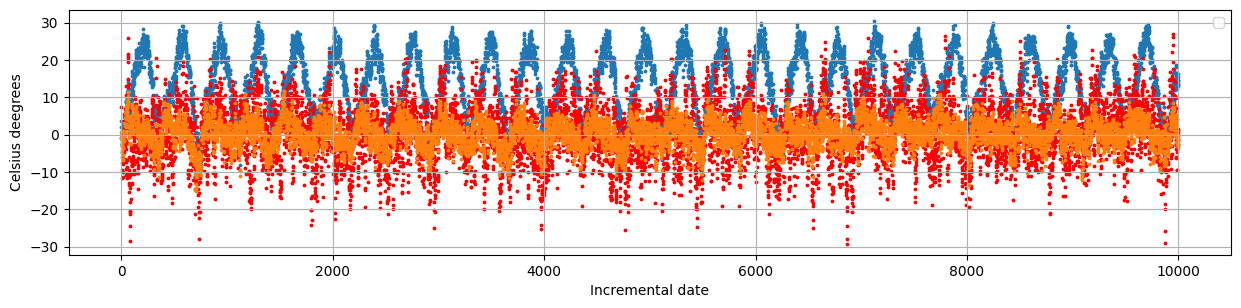

In [ ]:
ax = pl.figure(figsize=(15,7)).add_subplot(211)
ax.scatter(parma_x[0:10000],parma_y[0:10000], s=3)
ax.scatter(parma_x[0:10000],parma_y[0:10000]-y_sim_parma[0:10000], color = "red", s = 3)
ax.scatter(parma_x[0:10000],parma_y[0:10000]-y_fit_parma[0:10000], s = 3)
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.grid(True)

#Monte Carlo Pricing


Focusing on the Heating Degree Days index
$$ HDD = \sum_{t_{start}}^{t_{end}} max(0, T_b-T_t)$$
Where T_b is a base temperature defined in the contract, it represente the outside temperature at which the heating is turned on inside a given building, usually $15.5^{\circ}C$.


In [ ]:
Tb = 15.5
Delta = 90 #duration of the contract in days

#starting from Oct 1st 2000 with temperature
contract_start = datetime(year=2000, month=10, day=1)
t_start = (contract_start - start_date).days
print(t_start)
print(start_date)
print(len(x))

2100
1995-01-01 00:00:00
9259


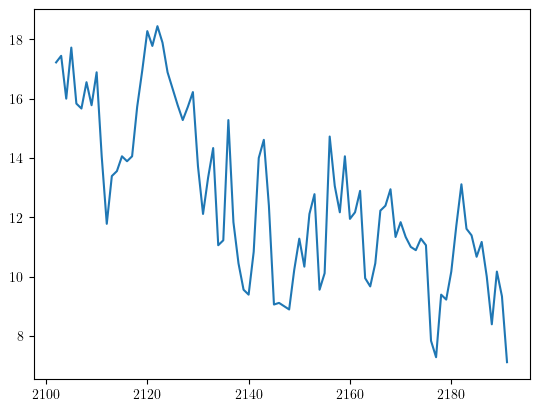

In [ ]:
pl.plot(x[t_start:t_start+Delta],y[t_start:t_start+Delta])

In [ ]:
x_sim = np.arange(91) + t_start
MC_steps = 10000
dayval = np.zeros((len(x_sim), MC_steps))

np.random.seed(199)
random.seed(199)
HDDs = np.zeros(int(MC_steps))
for j in range(int(MC_steps)):
  for i in range(len(x_sim)-1):
    dayval[i+1,j] = np.random.normal(np.exp(-k)*dayval[i,j], np.sqrt(integral2(i)))
  dayval[:,j] = dayval[:,j] + s(x_sim,*params)
  HDD = np.maximum(0,Tb-dayval[:,j])
  HDDs[j] = HDD.sum()


In [ ]:
fig, ax = pl.subplots(figsize=(7, 5))
ax.plot(x_sim-t_start, dayval[:,1:50], linewidth = 1, color = "black", alpha = 0.2)
ax.plot(x_sim-t_start, dayval[:,-1], linewidth = 1, color = "black", alpha = 0.2, label = "simulations")
ax.plot(x_sim-t_start,y[t_start:t_start+Delta+1], label="real data", color = "blue")
ax.plot(x_sim-t_start, s(x[t_start:t_start+Delta+1],*params), label="seasonality", color = "red")
ax.set_title("Temperature paths")
ax.legend()
ax.set_xlabel("Days from contract start")
ax.set_ylabel(r"Daily average temperature $^{\circ}C$")
ax.set_xlim([0,90])


(0.0, 90.0)

In [ ]:
HDD_real = np.sum(np.maximum(0,Tb-y[t_start:t_start+Delta]))
print(HDD_real)

282.50000000000006


Hdd strike:  376.2555067888522


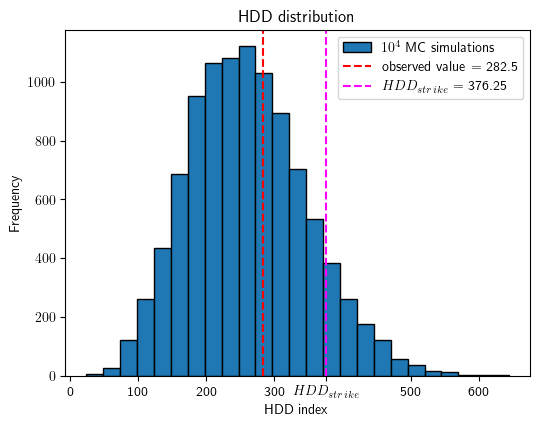

In [ ]:
fig, ax = pl.subplots(figsize=(6, 4.5))
HDD_strike = np.percentile( HDDs, [50, 90])


ax.hist(HDDs,bins=25, edgecolor='black', label=r"$10^4$ MC simulations")
ax.axvline(x=HDD_real, color='red', linestyle='--', label='observed value = 282.5')
ax.axvline(x=HDD_strike[1], color='magenta', linestyle='--', label=r'$HDD_{strike}$ = 376.25')
ax.set_title("HDD distribution ")
ax.set_xlabel("HDD index")
ax.set_xticks([0,100,200,300,HDD_strike[1],500,600])
ax.set_xticklabels([0,100,200,300,r"$HDD_{strike}$",500,600])
ax.set_ylabel("Frequency")
ax.legend()


print("Hdd strike: ", HDD_strike[1])

Computation of the payoff:
$$E(min((HDD-HDD_{strike})^+, L))$$

In [ ]:
#general plot for the payoff
HDDp_strike = 400
L = 400
x_payoff = np.arange(10000)/10
y_payoff = np.minimum(np.maximum(x_payoff-HDDp_strike,0),L)


fig, ax = pl.subplots(figsize=(5, 3))
ax.set_title("Temperature Derivative Payoff")
ax.plot(x_payoff,y_payoff)
ax.set_xlabel("HDD value")
ax.set_ylabel("Payoff")
ax.set_xticks([0,200,400,600,800,1000])
ax.set_xticklabels(["0","200","HDD strike", "600", "L", "1000"]);




In [ ]:
V = np.mean(np.minimum(np.abs(HDDs - HDD_strike[1]), np.inf))
print(V)
save3 = 63.46091136435298 #con 1e5 passi

125.45071231876928


In [ ]:

contract_start = datetime(year=1995, month=12, day=1)
t_start = (contract_start - start_date).days
MC_steps = 1e3
HDD_strike = 200
V_sim = np.zeros(365)
V_real = np.zeros(365)

for k in range(int(365)):
  t_s = k+t_start
  x = np.arange(90) + t_start
  y_real = y[t_start:t_start+89]
  HDDs = np.zeros(int(MC_steps))

  for j in range(int(MC_steps)):
    for i in range(len(x)-1):
      y_temp = np.zeros(len(x))
      y_temp[i+1] = np.random.normal(np.exp(-k)*y_temp[i], np.sqrt(integral2(i)))
    y_temp = y_temp + s(x,*params)
    y_cum = y_cum + y_pr
    HDD = np.maximum(0,Tb-y_temp)
    HDDs[j] = HDD.sum()

  HDD_real = np.maximum(0,Tb-y_real).sum()
  V_sim[k] = np.mean(np.minimum(np.abs(HDDs - HDD_strike), np.inf))
  V_real[k] = np.minimum(np.abs(HDD_real - HDD_strike), np.inf)


KeyboardInterrupt: 

In [ ]:

pl.plot(V_real)

NameError: name 'V_real' is not defined

#LSTM model


In [ ]:
import plotly.express as px
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# set plotly parameters
import plotly.io as pio
pio.renderers.default='notebook'

In [ ]:
# Get the close data as input data
input_data = parma_y # get the close price (true prices)
input_data = input_data.reshape(-1,1) # reshape to column vector

# scale to [0,1] again
sc = MinMaxScaler()
input_scaled = sc.fit_transform(input_data)
input_scaled

In [ ]:
# Create the training and testing data, training data contains present day and previous day values
X = []
Y = []
for i in range(1, len(input_scaled)):
    X.append(input_scaled[i-1:i, 0])
    Y.append(input_scaled[i, 0])

# Convert the data into array format
X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape



In [ ]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.2
)

# estimate the R2 on the test set
print("LSTM coefficient of determination of the prediction: ", r2_score(y_test, model.predict(X_test)))

In [ ]:
# Make prediction
#predicted = model.predict(X)
predicted = model.predict(np.reshape(X, (X.shape[0], X.shape[1], 1)))

# make list
predicted = predicted.ravel().tolist()

# make dataframe
df_predicted = raw_Parma[1:][['date']]
df_predicted['predictions'] = predicted
df_predicted['Close'] = input_scaled[1:]
df_predicted

# Plot the data
fig = px.line(df_predicted, x='date', y=df_predicted.columns[1:], title="Original Vs Prediction")
fig.add_vline(x=df_predicted.date[1798])
fig.show()

In [ ]:
ax = pl.figure(figsize=(15,7)).add_subplot(111)
ax.plot(parma_x[30000:30500],input_scaled[30000:30500], label = "Data", linewidth = 1)
ax.plot(parma_x[30000:30500],predicted[30000:30500], 'r-', label='Fitted Function', linewidth = 1)
ax.set_title("Complete seasonality fit for Parma data(Zoom)")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date from 1st jan 1900")
ax.legend()
ax.grid(True)